# Import Libraries

In [332]:
import cv2
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from scipy.signal import find_peaks
import pandas as pd

# Definition of Functions

### 1 - Find Contours

In [333]:
# First method to find contours
def find_contours_label_1(image, area):
    # Process to find contours
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    binary = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours based on a mininum area proportion
    image_area = image.shape[0] * image.shape[1]
    min_area = area * image_area
    filtered_contours = [contour for contour in contours if cv2.contourArea(contour) > min_area]

    # Draw new contour
    mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
    cv2.drawContours(mask, filtered_contours, -1, 255, thickness=2)
    merged_contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Select the top 1 with biggest area
    contour_areas = [(contour, cv2.contourArea(contour)) for contour in merged_contours]  # Pair each contour with its area
    sorted_contours = sorted(contour_areas, key=lambda x: x[1], reverse=True)  # Sort contours by area ascending
    top_1_contours = [contour for contour, area in sorted_contours[:1]]

    # Draw the contours
    mask2 = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    cv2.drawContours(image, top_1_contours, -1, (0, 255, 0), thickness=5)
    cv2.drawContours(mask2, top_1_contours, -1, (0, 255, 0), thickness=5)

    return top_1_contours, mask2

In [334]:
# Second method to find contours
def find_contours_label_2(image, area):
    # Process to find contours
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    binary = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours based on a mininum area proportion
    image_area = image.shape[0] * image.shape[1]
    min_area = area * image_area
    filtered_contours = [contour for contour in contours if cv2.contourArea(contour) > min_area]

    # Draw new contour
    mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
    cv2.drawContours(mask, filtered_contours, -1, 255, thickness=cv2.FILLED)
    merged_contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Select the top 1 with biggest area
    contour_areas = [(contour, cv2.contourArea(contour)) for contour in merged_contours]  # Pair each contour with its area
    sorted_contours = sorted(contour_areas, key=lambda x: x[1])  # Sort contours by area
    top_1_contours = [contour for contour, area in sorted_contours[:1]]

    # Draw the contours
    mask2 = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    cv2.drawContours(image, top_1_contours, -1, (0, 255, 0), thickness=5)
    cv2.drawContours(mask2, top_1_contours, -1, (0, 255, 0), thickness=5)
    
    return top_1_contours, mask2

In [335]:
def find_common_points_and_transform_contours(img1, contour_img1, img2):    
    # Convert images to grayscale
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    # Detect keypoints and descriptors
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(gray1, None)
    kp2, des2 = sift.detectAndCompute(gray2, None)
    
    # Match keypoints using BFMatcher
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(des1, des2)
    
    # Sort matches by distance
    matches = sorted(matches, key=lambda x: x.distance)
    
    # Extract the matched keypoints
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    
    # Estimate the transformation matrix
    M, mask = cv2.estimateAffinePartial2D(pts1, pts2)
    
    # Create a blank image to draw the transformed contours
    transformed_contours_image = np.zeros_like(img2)
    
    contour = max(contour_img1, key=cv2.contourArea)
    # Transform contours and draw them on the second image
    contour = np.array(contour).reshape(-1, 2)
    contour = np.hstack((contour, np.ones((contour.shape[0], 1)))) # Add a column of ones for affine transformation
    transformed_contour = cv2.transform(np.array([contour]), M)[0]
    transformed_contour = transformed_contour.astype(np.int32)
    cv2.drawContours(transformed_contours_image, [transformed_contour], -1, (0, 255, 0), 5) 

    mask_gray = cv2.cvtColor(transformed_contours_image, cv2.COLOR_BGR2GRAY)
    contours, _ = cv2.findContours(mask_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Find the contour with the maximum area
    max_contour = max(contours, key=cv2.contourArea)
    
    return max_contour, transformed_contours_image

In [336]:
def align_images(img1, img2):
    # Convert images to grayscale
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Detect keypoints and compute descriptors
    keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)
    
    # Initialize FLANN-based matcher
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    
    # Match descriptors
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)
    
    # Store all good matches as per Lowe's ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)
    
    if len(good_matches) > 10:
        # Extract location of good matches
        src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 2)
        dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 2)
        
        # Find homography
        M, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)
        
        # Warp the test image to align with the original image
        height, width, channels = img1.shape
        good_image_aligned = cv2.warpPerspective(img2, M, (width, height))
        
        return good_image_aligned, M, keypoints1, keypoints2, good_matches
    else:
        print("Not enough matches are found - {}/{}".format(len(good_matches), 10))
        return None, None, None, None, None

In [337]:
# Function to shrink the contours by a number of pixels
def erode_contours(contours, pixels):
    eroded_contours = []
    kernel = np.ones((pixels * 2 + 1, pixels * 2 + 1), np.uint8)
    
    for contour in contours:
        # Create a mask for the contour
        x, y, w, h = cv2.boundingRect(contour)
        mask = np.zeros((h + 2 * pixels, w + 2 * pixels), dtype=np.uint8)
        contour_shifted = contour - contour.min(axis=0)[0] + pixels
        cv2.drawContours(mask, [contour_shifted], -1, 255, thickness=cv2.FILLED)
        
        # Erode the mask
        eroded_mask = cv2.erode(mask, kernel, iterations=1)
        
        # Find the new contour
        eroded_contour, _ = cv2.findContours(eroded_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if eroded_contour:  # Check if erosion resulted in a valid contour
            eroded_contour = eroded_contour[0] + contour.min(axis=0)[0] - pixels
            eroded_contours.append(eroded_contour)
        else:
            # In case erosion results in no contour, append an empty contour
            eroded_contours.append(np.array([]))
    
    return eroded_contours

# Steps of Inspection

In [338]:
# Setup variables
input_label_type = "single" #single or double
input_min_area_double = 0.4
input_min_area_single = 0.75

'''
    There are two possible types of contours, "single" or "double".
    Single type happens when theere is only one black border delimiting the main contour
    Double type happens when there are two delimeters to the main contour
'''

'\n    There are two possible types of contours, "single" or "double".\n    Single type happens when theere is only one black border delimiting the main contour\n    Double type happens when there are two delimeters to the main contour\n'

In [339]:
# Step 1: Load the images

#Rótulo 1
original_image = cv2.imread('D:/OneDrive/Facens/TCC - Projeto Final/Amostras/Fotos3/Rotulo 1/1 - Original.jpg')
good_image = cv2.imread('D:/OneDrive/Facens/TCC - Projeto Final/Amostras/Fotos3/Rotulo 1/2 - Test.jpeg')
test_image = cv2.imread('D:/OneDrive/Facens/TCC - Projeto Final/Amostras/Fotos3/Rotulo 1/1 - Good.jpeg')


In [340]:
# Find contours of the original label
original_image_contour, mask_original_image = find_contours_label_2(original_image, input_min_area_double) if input_label_type == "double" else find_contours_label_1(original_image, input_min_area_single)
#original_image_contour, mask_original_image = find_contours_label_1(original_image, input_min_area_single)

In [341]:
good_image_contour, mask_good_image = find_common_points_and_transform_contours(original_image, original_image_contour, good_image)
#bad_image_contour, mask_bad_image = find_common_points_and_transform_contours(original_image, original_image_contour, bad_image)
test_image_contour, mask_test_image = find_common_points_and_transform_contours(original_image, original_image_contour, test_image)

original_image_contour = erode_contours(original_image_contour, 5)

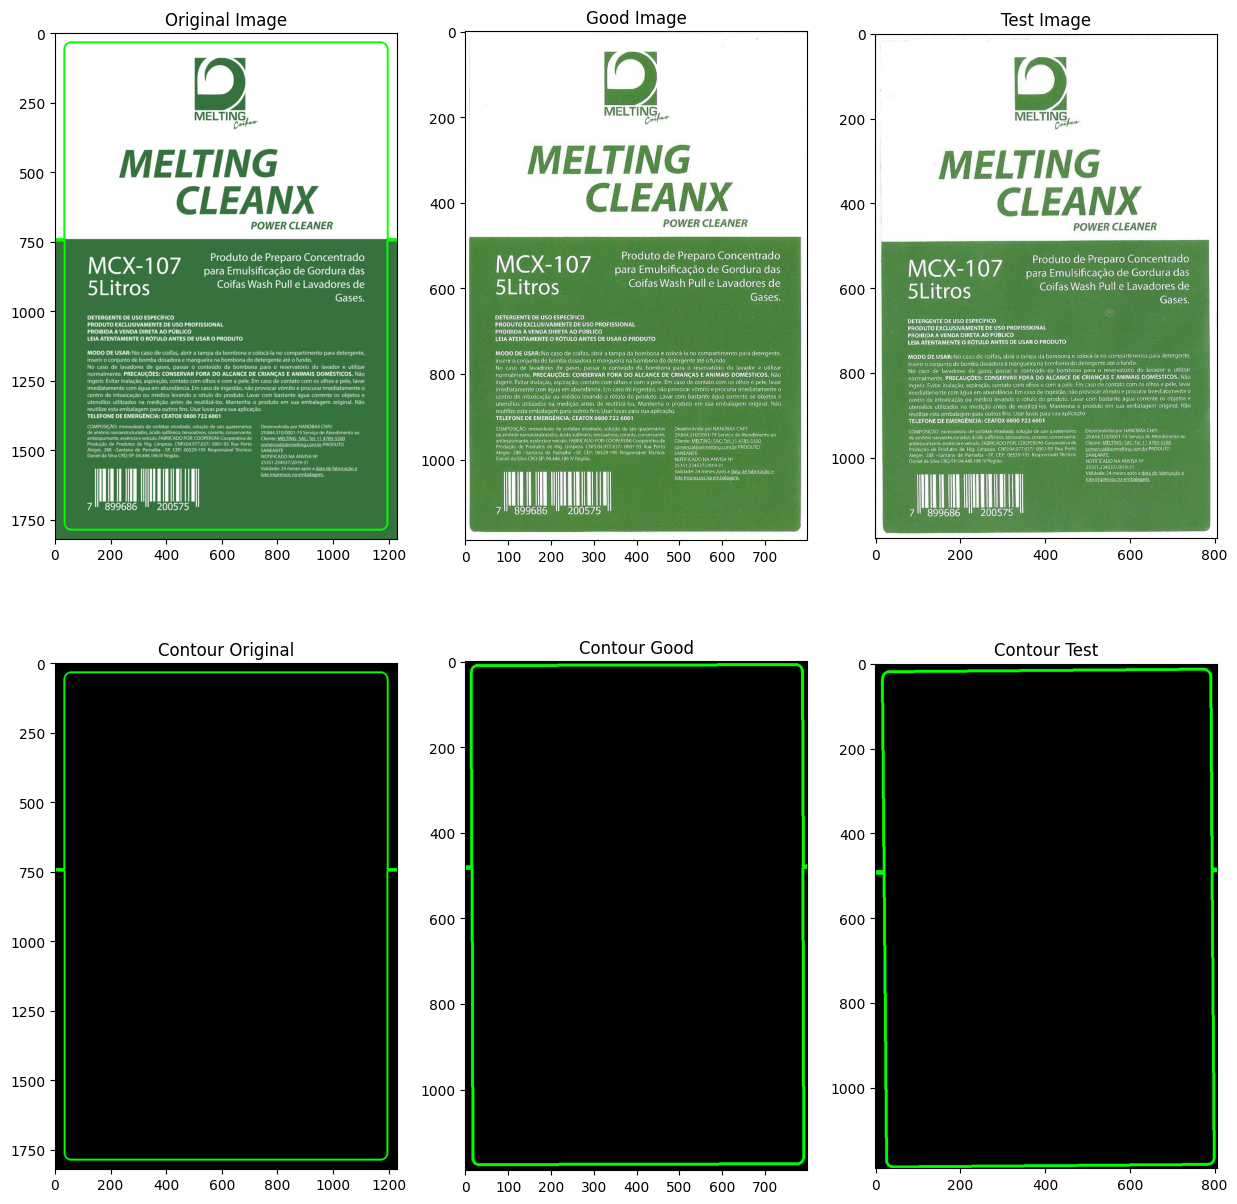

In [342]:
titles = ['Original Image', 'Good Image', 'Test Image','Contour Original', 'Contour Good', 'Contour Test']
#images = [original_image, good_image, bad_image_aligned, mask_original_image, mask_good_image, mask_bad_image_aligned]
images = [original_image, good_image, test_image, mask_original_image, mask_good_image, mask_test_image]
# Display the images
plt.figure(figsize=(15, 15))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.title(titles[i])
    plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
plt.show()

In [343]:
# Match keypoints of original label and test label
good_image_aligned, homography_matrix, keypoints1, keypoints2, good_matches = align_images(original_image, good_image)
#bad_image_aligned, homography_matrix, keypoints1, keypoints2, good_matches = align_images(original_image, bad_image)
test_image_aligned, homography_matrix, keypoints1, keypoints2, good_matches = align_images(original_image, test_image)

## 1 - Color Analysis

#### 1.1 - Functions

In [344]:
def plot_histogram_inside_contour(image, contour, topNpeaks=0):
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    cv2.drawContours(mask, contour, -1, 255, thickness=cv2.FILLED)
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    
    # Calculate the histogram for each color channel
    colors = ('r', 'g', 'b')
    histogram = {}
    peaks = {}
    meanval = []
    
    for i, color in enumerate(colors):
        histogram[color] = cv2.calcHist([masked_image], [i], None, [250], [1, 250])
        # Normalize histogram
        histogram[color] = cv2.normalize(histogram[color], histogram[color], 0, 1, cv2.NORM_MINMAX)

        # Get the peaks value, divide by two and find the mean between the peaks' half
        meanval.append(histogram[color][np.argmax(histogram[color])][0]/2)
        peakThreshold = np.mean(meanval[i])
        
        # Find peaks in the histogram
        peak_indices, _ = find_peaks(histogram[color].flatten(), height=peakThreshold)  # Change the height parameter as needed
        peak_values = [(index, histogram[color][index][0]) for index in peak_indices]
        
        if topNpeaks > 0:
            # Get the indices of the top 3 peaks
            sorted_indices = np.argsort(histogram[color].flatten())[-1*topNpeaks:]  # Indices of top 3 values
            sorted_indices = sorted_indices[::-1]  # Reverse to get descending order
            # Store the top 3 peaks (index and value)
            peaks[color] = [(int(idx), histogram[color][idx][0]) for idx in sorted_indices]
        else:
            peaks[color] = peak_values  # Store list of peaks for each color channel
 
    return histogram, masked_image, peaks

In [345]:
# Function to calculate mean and standard deviation of intensity values around peaks
def calculate_mean_std(hist, peaks, window_size=10):
    means = {color: [] for color in peaks.keys()}
    stds = {color: [] for color in peaks.keys()}

    for color, peak_list in peaks.items():
        for peak_index, peak_value in peak_list:
            # Define the window around the peak
            start_index = max(0, peak_index - window_size)
            end_index = min(len(hist[color]), peak_index + window_size + 1)

            # Extract the counts and intensity values around the peak
            values_around_peak = hist[color][start_index:end_index]
            bins = np.arange(start_index, end_index)  # Create bins corresponding to the extracted values
            total_pixels = np.sum(values_around_peak)

            if total_pixels == 0:
                mean, std = 0, 0  # Avoid division by zero
            else:
                # Calculate mean of intensity values around the peak
                mean = peak_index
                variance = np.sum(values_around_peak.flatten() * (bins - mean) ** 2) / total_pixels
                std = np.sqrt(variance)

            # Append the mean and std to the respective lists
            means[color].append(mean)
            stds[color].append(std)

    return means, stds

In [346]:
# Generate the dataframe of results
def create_peak_dataframe(peaks, means, stds):
    # Prepare a DataFrame structure
    results = []

    # Determine the maximum number of peaks across colors
    max_peaks = max(len(peaks['b']), len(peaks['g']), len(peaks['r']))

    # Iterate through peaks and prepare statistics for each color
    for peak_id in range(max_peaks):
        row = {'Id': f'Peak {peak_id + 1}'}
        
        for color in ('r', 'g', 'b'):
            if peak_id < len(peaks[color]):
                # Get mean and std from the passed dictionaries
                row[f'Mean {color.upper()}'] = means[color][peak_id]
                row[f'Std Dev {color.upper()}'] = stds[color][peak_id]
            else:
                # Handle case where there are fewer peaks than expected
                row[f'Mean {color.upper()}'] = None
                row[f'Std Dev {color.upper()}'] = None

        results.append(row)

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df

#### 1.2 - Execution

In [347]:
# Plot the histogram of colors inside the contour
hist_original, masked_original, original_peaks = plot_histogram_inside_contour(original_image, original_image_contour)

# number of peaks
colors = ('r', 'g', 'b')
qty = []
for i, c in enumerate(colors):
    qty.append(len(original_peaks[c]))
topNpeaks = max(qty) if qty else None

hist_good, masked_good, good_peaks = plot_histogram_inside_contour(good_image_aligned, original_image_contour)
#hist_bad, masked_bad, bad_peaks = plot_histogram_inside_contour(bad_image_aligned, original_image_contour)
hist_test, masked_test, test_peaks = plot_histogram_inside_contour(test_image_aligned, original_image_contour)

In [348]:
# Compute means, standard deviations, and similarities
means_original, stds_original = calculate_mean_std(hist_original, original_peaks)
means_good, stds_good = calculate_mean_std(hist_good, good_peaks)
#means_bad, stds_bad = calculate_mean_std(hist_bad, bad_peaks)
means_test, stds_test = calculate_mean_std(hist_test, test_peaks)

In [349]:
df_original = create_peak_dataframe(original_peaks, means_original, stds_original)
df_good = create_peak_dataframe(good_peaks, means_good, stds_good)
#df_bad = create_peak_dataframe(bad_peaks, means_bad, stds_bad)
df_test = create_peak_dataframe(test_peaks, means_test, stds_test)

# Add a new column to each DataFrame to identify the type
df_original['Type'] = 'Original'
df_good['Type'] = 'Good'
#df_bad['Type'] = 'Bad'
df_test['Type'] = 'Test'

# Combine the DataFrames by rows
combined_df = pd.concat([df_original, df_good, df_test], ignore_index=True)

In [350]:
combined_df

Id  Mean R  Std Dev R  Mean G  Std Dev G  Mean B  Std Dev B      Type
0  Peak 1      61   1.704349     113   1.599839      53   1.735274  Original
1  Peak 1      61   5.404148     132   5.352464      75   5.467964      Good
2  Peak 1      69   5.396641     134   5.290277      79   5.425383      Test

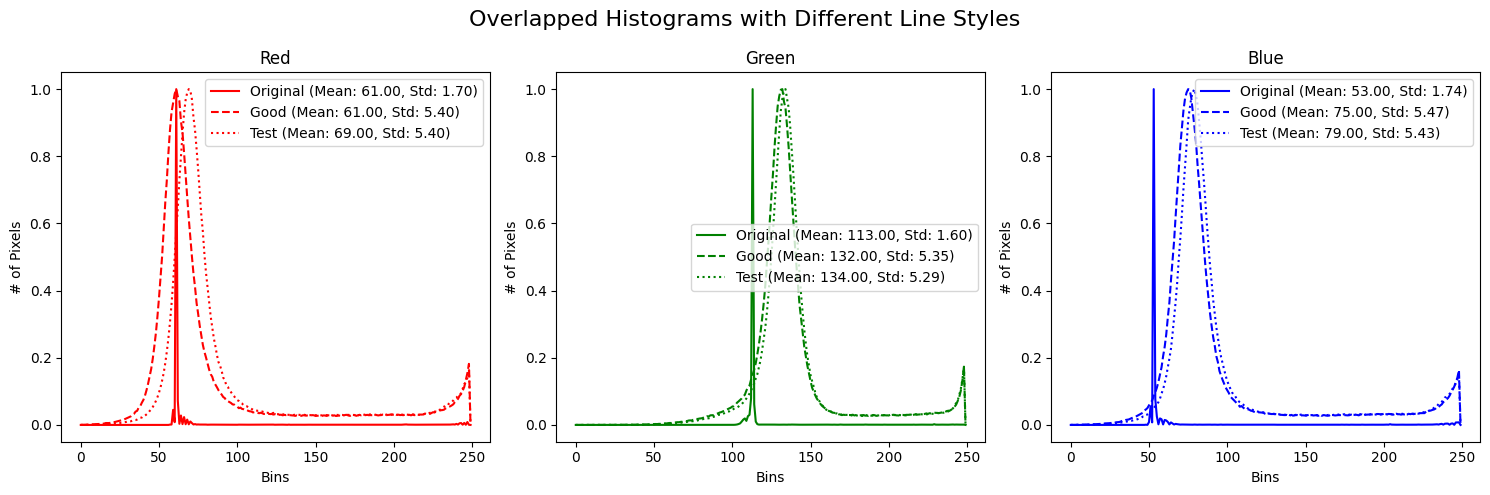

In [351]:
titles = ['Red','Green','Blue']
# Display the images
plt.figure(figsize=(15, 5))
for i, color in enumerate(colors):
    bins = np.arange(1, 251)
    plt.subplot(1,3,i+1)
    plt.title(titles[i])

   # Plot histograms
    plt.plot(hist_original[color], '-', color=color, label=f'Original (Mean: {means_original[color][0]:.2f}, Std: {stds_original[color][0]:.2f})')
    plt.plot(hist_good[color], '--', color=color, label=f'Good (Mean: {means_good[color][0]:.2f}, Std: {stds_good[color][0]:.2f})')
    plt.plot(hist_test[color], ':', color=color, label=f'Test (Mean: {means_test[color][0]:.2f}, Std: {stds_test[color][0]:.2f})')

    # Add legend for each subplot
    plt.legend()

    # Add labels and title for each subplot
    plt.xlabel('Bins')
    plt.ylabel('# of Pixels')

plt.suptitle('Overlapped Histograms with Different Line Styles', fontsize=16)
plt.tight_layout()
plt.show()

## 2 - Stain Detection

#### 2.1 - Functions

In [352]:
# Black out the content outside of the original contour
def get_image_inside_contour(image, contour):
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    cv2.drawContours(mask, contour, -1, 255, thickness=cv2.FILLED)
    masked_image = cv2.bitwise_and(image, image, mask=mask)

    return masked_image

In [353]:
# Computes the difference between two images, thresholds it, applies blur, finds contours, and displays the results.
def display_image_difference(img1, img2, threshold, blur_ksize=5, contour_thresh=25):
    # Convert images to grayscale
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Compute absolute difference between the images
    diff = cv2.absdiff(gray1, gray2)

    # Threshold the difference image to get a binary mask
    _, thresh_diff = cv2.threshold(diff, threshold, 255, cv2.THRESH_BINARY)

    # Apply Gaussian blur to the thresholded difference image
    blurred_diff = cv2.GaussianBlur(thresh_diff, (blur_ksize, blur_ksize), 0)

    # Apply additional thresholding to the blurred difference image
    _, thresh_blurred_diff = cv2.threshold(blurred_diff, contour_thresh, 255, cv2.THRESH_BINARY)

    # Find contours in the thresholded blurred difference image
    contours, _ = cv2.findContours(thresh_blurred_diff, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours on the blurred difference image
    contours_img = cv2.cvtColor(blurred_diff, cv2.COLOR_GRAY2BGR)  # Convert to color image for contour drawing
    cv2.drawContours(contours_img, contours, -1, (0, 255, 0), 2)  # Draw contours in green

    # Prepare titles and images for plotting
    titles = ['Difference Threshold', 'Blurred Difference', 'Contours on Blurred Difference']
    images = [thresh_diff, blurred_diff, thresh_blurred_diff]

    # Plot the images
    plt.figure(figsize=(20, 10))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(titles[i])
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')  # Hide axis for cleaner display
    plt.show()

    return thresh_blurred_diff

In [354]:
# Dilates the given contours by a fixed number of pixels.
def dilate_contours(contours, pixels):
    dilated_contours = []
    kernel = np.ones((pixels * 2 + 1, pixels * 2 + 1), np.uint8)
    
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        mask = np.zeros((h + 2 * pixels, w + 2 * pixels), dtype=np.uint8)
        contour_shifted = contour - contour.min(axis=0)[0] + pixels
        cv2.drawContours(mask, [contour_shifted], -1, 255, thickness=cv2.FILLED)
        
        # Dilate the mask
        dilated_mask = cv2.dilate(mask, kernel, iterations=1)
    
        # Find the new contour
        dilated_contour, _ = cv2.findContours(dilated_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        dilated_contour = dilated_contour[0] + contour.min(axis=0)[0] - pixels
        dilated_contours.append(dilated_contour)
    
    return dilated_contours

In [355]:
# Blacks out all pixels inside the provided contours in the given image by filling each contour.
def paint_contours(image, contours):
    output_image = image.copy()

    # Loop through each contour and fill it with black
    for contour in contours:
        # Draw the filled contour with black (0) on the output image
        cv2.drawContours(output_image, [contour], -1, 0, thickness=cv2.FILLED)

    return output_image

In [356]:
# Create a mask for given contours and image shape.
def create_contour_mask(contours, shape):
    mask = np.zeros(shape, dtype=np.uint8)
    for contour in contours:
        cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)
    return mask

In [357]:
# Check if there is any overlap between two masks.
def contour_overlap_pixelwise(c1_mask, c2_mask):
    overlap = cv2.bitwise_and(c1_mask, c2_mask)
    return np.any(overlap > 0)

In [358]:
# Match contours based on pixel-wise overlap and return contours that are not matched.
def match_contours_by_pixelwise_overlap(c1_list, c2_list, image_shape):
    unmatched_c1 = []
    matched_c2 = []
    
    # Create masks for contours
    c1_masks = [create_contour_mask([c1], image_shape) for c1 in c1_list]
    c2_masks = [create_contour_mask([c2], image_shape) for c2 in c2_list]
    
    for i, mask1 in enumerate(c1_masks):
        match_found = False
        for j, mask2 in enumerate(c2_masks):
            if contour_overlap_pixelwise(mask1, mask2):
                match_found = True
                matched_c2.append(c2_list[j])
                break
        if not match_found:
            unmatched_c1.append(c1_list[i])
    
    return unmatched_c1, [c2 for c2 in c2_list if c2 not in matched_c2]

In [359]:
# Applies contours to two images, dilates the contours in the first image,
# blacks out the areas in the third image, and displays the results.
# Filters contours to keep only those where 100% of the points are inside the major contour,
# and the contour's area is less than 50% of the image area.

def apply_contours_to_images(img1, img2, img3, major_contour, threshold=25, pixels=5):
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    thresh1 = cv2.adaptiveThreshold(
        gray1, 255, 
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY_INV, 
        11, 2
    )
    thresh2 = cv2.adaptiveThreshold(
        gray2, 255, 
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY_INV, 
        11, 2
    )

    contours1, _ = cv2.findContours(thresh1, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours2, _ = cv2.findContours(thresh2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Dilate the contours in img1
    dilated_contours1 = dilate_contours(contours1, pixels)

    # Compute the image area and set the maximum contour area to 50% of the image area
    image_area = img1.shape[0] * img1.shape[1]
    max_contour_area = 0.5 * image_area

    # Filter contours by checking area and if 100% of their points are inside the major_contour
    filtered_contours = []
    for contour in dilated_contours1:
        contour_area = cv2.contourArea(contour)

        if contour_area < max_contour_area:
            filtered_contours.append(contour)
            

    # Black out the areas in img3
    img3_blackened = paint_contours(img3, filtered_contours)

    # Draw contours on the original images
    img1_contours = img1.copy()
    img2_contours = img2.copy()

    cv2.drawContours(img1_contours, filtered_contours, -1, (0, 255, 0), 2)  
    cv2.drawContours(img2_contours, contours2, -1, (0, 255, 0), 2)  

    # Prepare titles and images for plotting
    titles = ['Original Image With Filtered Contours', 'Thresholded Image', 'Blackened Image']
    images = [img1_contours, img3, img3_blackened]

    # Plot the images
    plt.figure(figsize=(20, 20))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(titles[i])
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.axis('off')  # Hide axis for cleaner display
    plt.show()

    return img3_blackened

In [360]:
# Finds the centroids of the given contours
def find_contour_centroids(contours):
    centroids = []
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            centroids.append((cX, cY))
        else:
            centroids.append((0, 0))
    return centroids

In [361]:
# Finds contours in the given image that contain the given centroids.
def find_contours_containing_centroids(image, centroids):
    if len(image.shape) == 3 and image.shape[2] == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    elif len(image.shape) == 2:
        gray = image
    else:
        raise ValueError("Unsupported image format")

    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    contours_containing_centroids = []
    for centroid in centroids:
        for contour in contours:
            if cv2.pointPolygonTest(contour, centroid, False) >= 0:
                contours_containing_centroids.append(contour)
                break  # Found the containing contour, no need to check further

    return contours_containing_centroids

In [362]:
# Generate the dataframe for final result of the inspection
def create_contour_dataframe(contours, image_area):
    data = []

    for i, contour in enumerate(contours):
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)

        # Calculate the centroid
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            centroid = (cx, cy)
        else:
            centroid = (0, 0)  # Default centroid if area is zero

        # Calculate the percentage of the area
        percent = (area / image_area) * 100 if image_area > 0 else 0

        data.append({
            'Id': f'Contour {i + 1}',
            'Contour': contour,
            'Area': area,
            'Perimeter': perimeter,
            'Percent': percent,
            'Centroid': centroid
        })

    df = pd.DataFrame(data)
    return df

#### 2.2 - Execution

In [363]:
# Plot the histogram of colors inside the contour
original_w_contour = get_image_inside_contour(original_image, original_image_contour)
#good_aligned_w_contour= get_image_inside_contour(good_image_aligned, original_image_contour)
#bad_aligned_w_contour = get_image_inside_contour(bad_image_aligned, original_image_contour)
test_aligned_w_contour = get_image_inside_contour(test_image_aligned, original_image_contour)

In [364]:
# Calculate the difference image
#dif_original_good = cv2.absdiff(original_w_contour, good_image_aligned)

# Create an overlapped image
#sum_original_good = cv2.addWeighted(original_w_contour, 0.5, good_image_aligned, 0.5, 0)

# Calculate the difference image
dif_original_test = cv2.absdiff(original_w_contour, test_image_aligned)

# Create an overlapped image
sum_original_test = cv2.addWeighted(original_w_contour, 0.5, test_image_aligned, 0.5, 0)

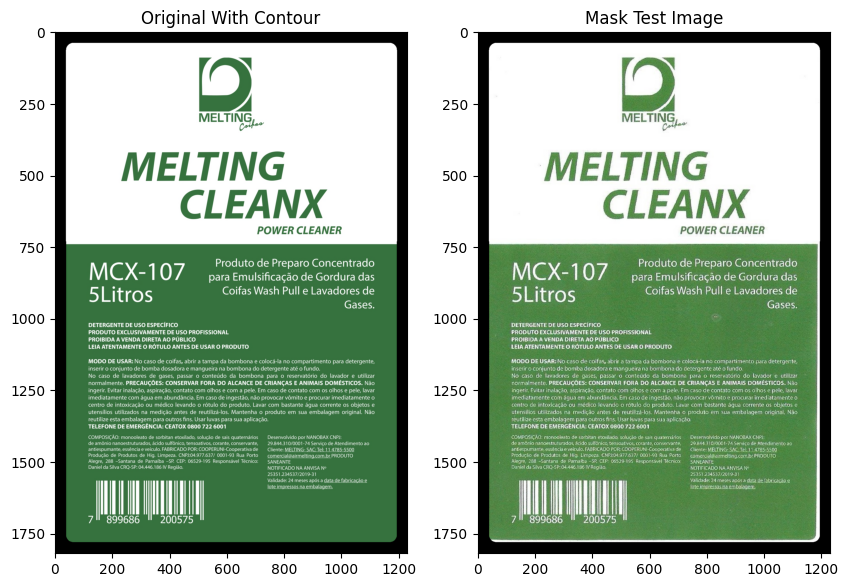

In [365]:
titles = ['Original With Contour', 'Mask Test Image']
images = [original_w_contour, test_aligned_w_contour]

# Display the first three images in one row
plt.figure(figsize=(10, 10))
for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.title(titles[i])
    plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
plt.show()

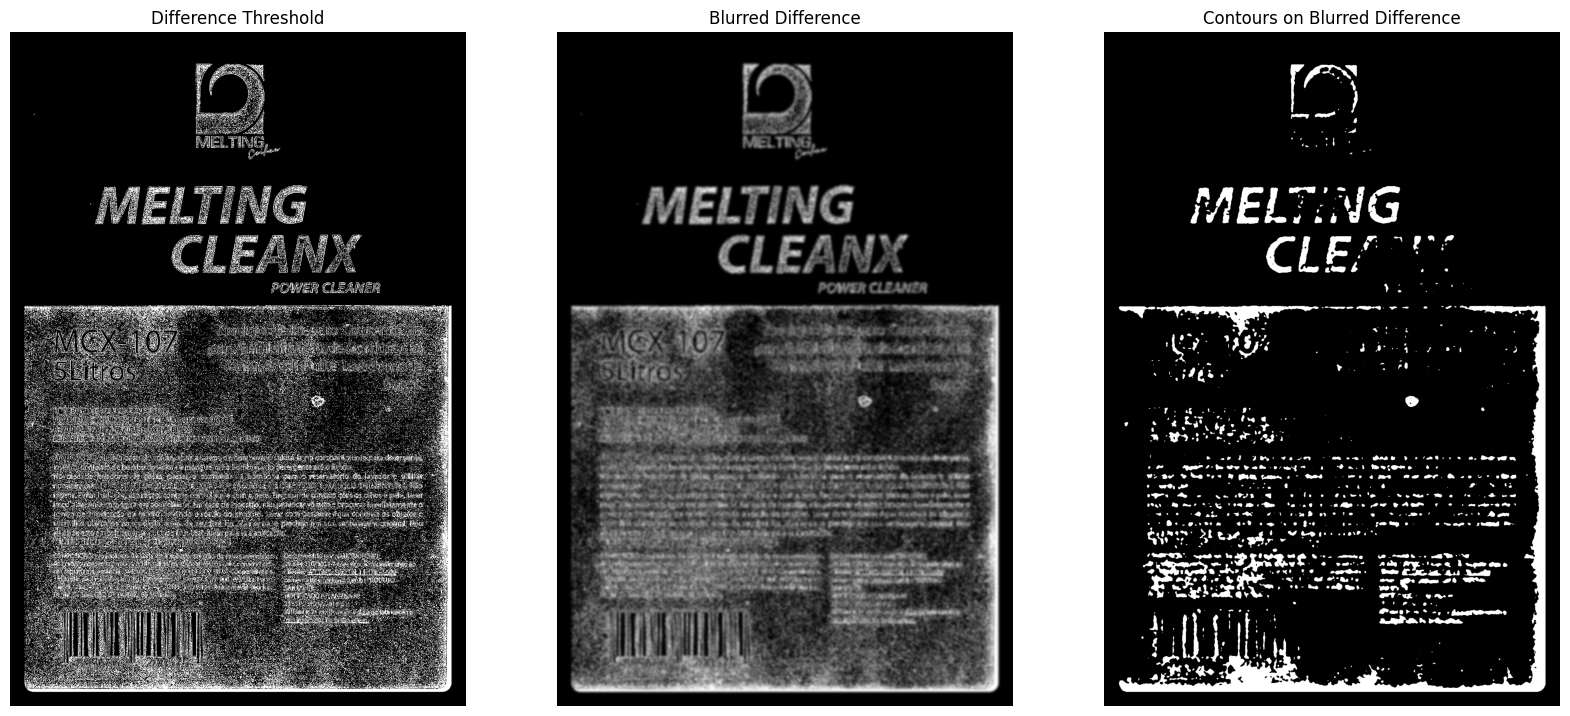

In [366]:
# Example usage (assuming original_w_contour and test_aligned_w_contour are defined):
threshed_diff = display_image_difference(original_w_contour, test_aligned_w_contour, 25, 17, 120)

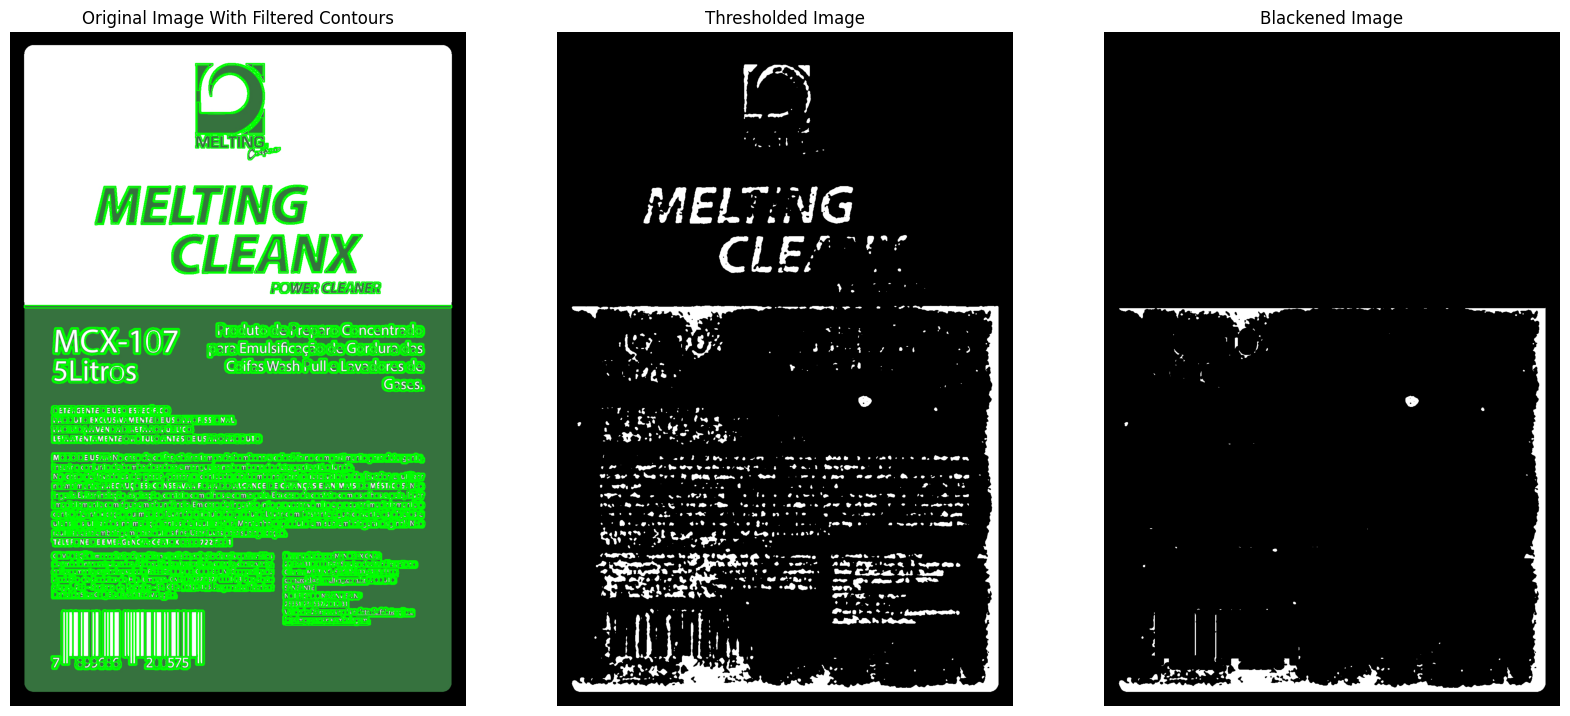

In [367]:
# Example usage (assuming original_w_contour, test_aligned_w_contour, and threshed_diff are defined):
img1_filtered = apply_contours_to_images(original_w_contour, test_aligned_w_contour, threshed_diff, original_image_contour[0], 150, 2)

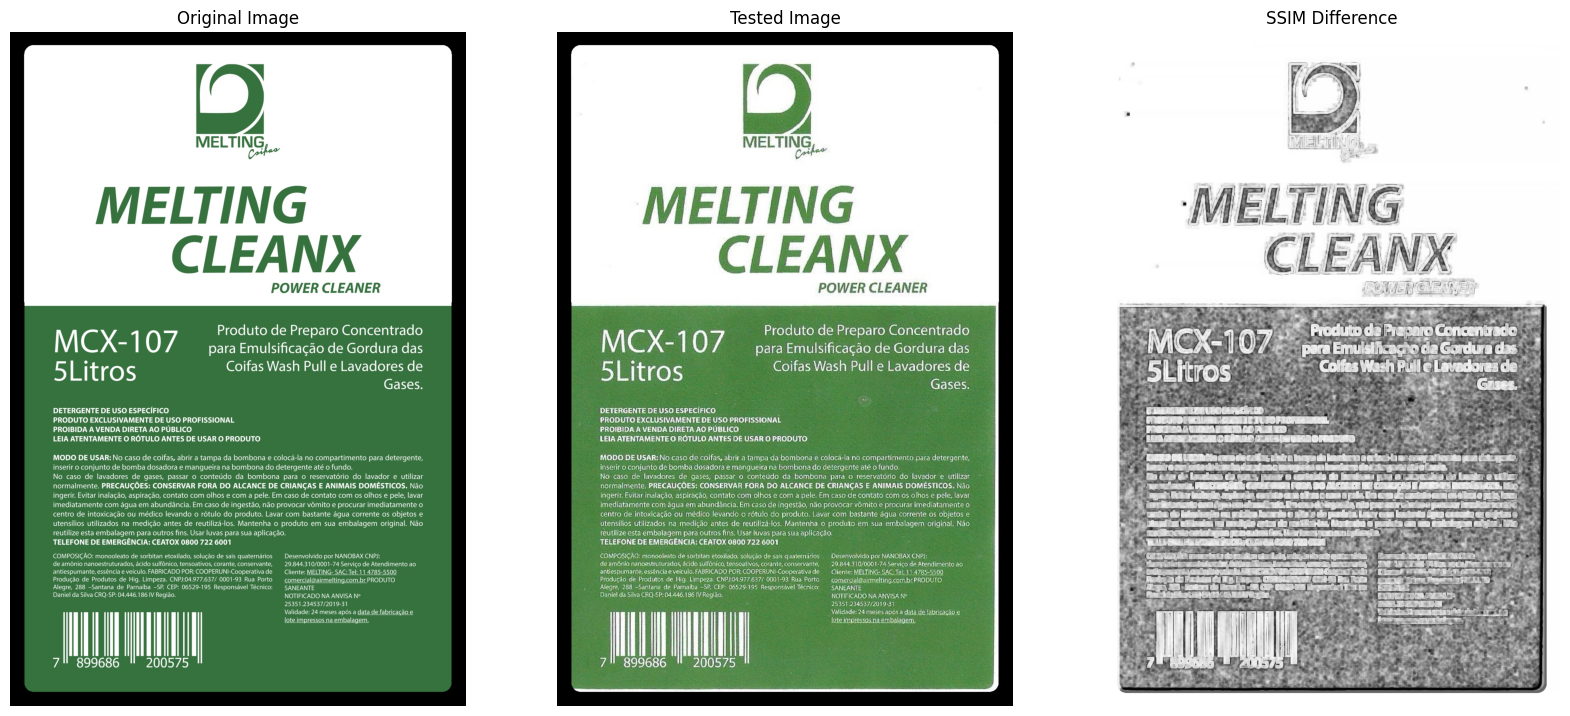

In [368]:
# Load images
original = original_w_contour.copy()
test = test_aligned_w_contour.copy()

# Convert images to grayscale
gray_original = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
gray_copy = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)

# Compute SSIM between the two images
score, diff = ssim(gray_original, gray_copy, full=True)
diff = (diff * 255).astype("uint8")

# Threshold the difference image
_, thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

# Display the images
titles = ['Original Image', 'Tested Image', 'SSIM Difference']
images = [original, test, diff]

plt.figure(figsize=(20, 20))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(titles[i])
    plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Optional: turn off axis for cleaner display
plt.show()


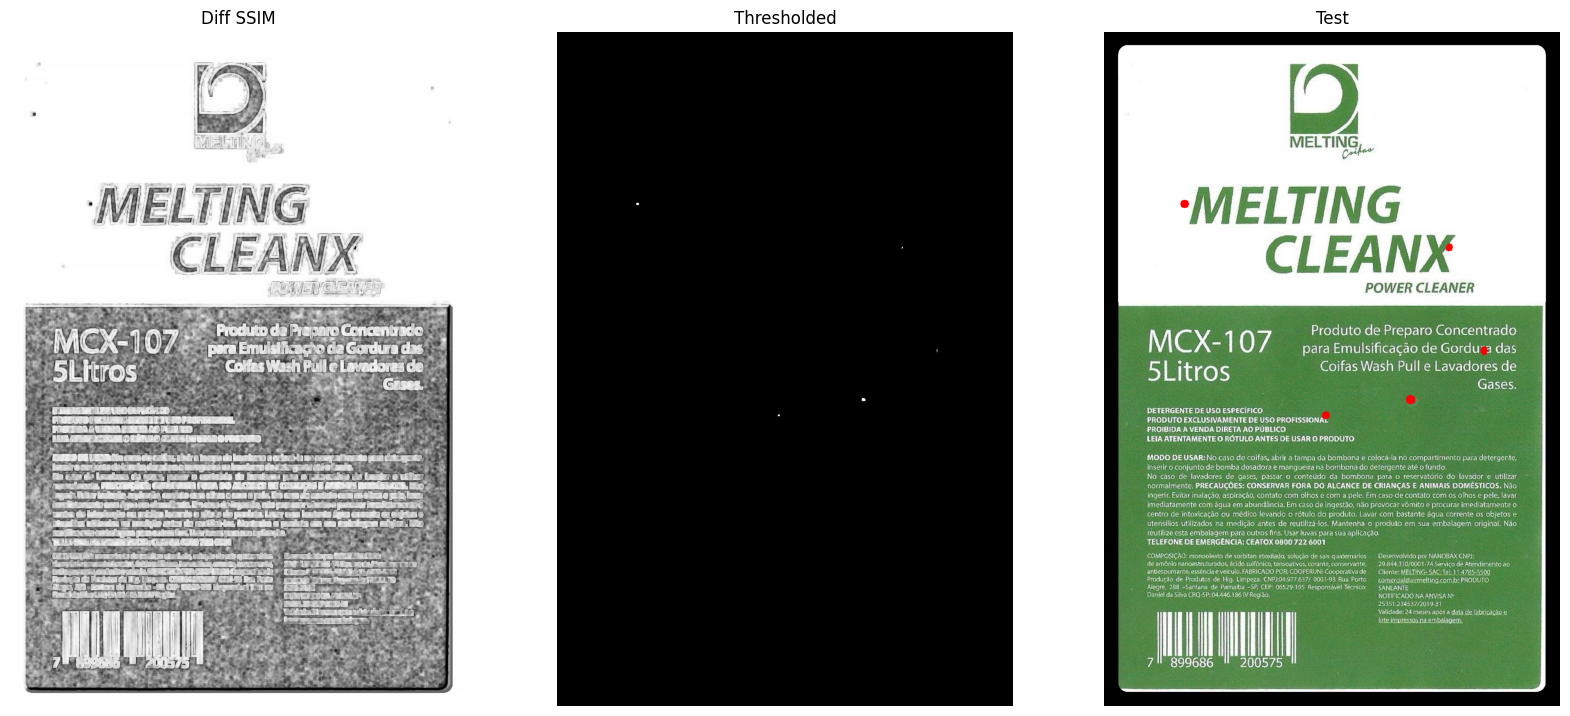

In [369]:
# Apply thresholding
# In this example, we set the threshold to 50 (adjust this value as needed)
top_n_stains = 5
threshold_value = 20
_, thresholded_image = cv2.threshold(diff, threshold_value, 255, cv2.THRESH_BINARY_INV)


# Get the dimensions of the image
height, width = thresholded_image.shape[:2]

# Calculate rectangle dimensions
rect_width = int(width * 0.9)
rect_height = int(height * 0.9)

# Calculate the top-left and bottom-right coordinates for the rectangle
top_left_x = (width - rect_width) // 2
top_left_y = (height - rect_height) // 2
bottom_right_x = top_left_x + rect_width
bottom_right_y = top_left_y + rect_height

mask = np.zeros((height, width), dtype=np.uint8)
cv2.rectangle(mask, (top_left_x, top_left_y), (bottom_right_x, bottom_right_y), (255), thickness=cv2.FILLED)
masked_image = cv2.bitwise_and(thresholded_image, thresholded_image, mask=mask)


contours, _ = cv2.findContours(masked_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# Sort contours by area in descending order and keep the top N
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:top_n_stains]


# Create a new mask with the same dimensions as the original
mask = np.zeros_like(mask)
# Draw the top N largest contours on the new mask
cv2.drawContours(mask, contours, -1, (255), thickness=cv2.FILLED)


new_img = test_aligned_w_contour.copy()
# Draw the contours on the difference image
cv2.drawContours(new_img, contours, -1, (0, 0, 255), 15)

# Display the images
titles = ['Diff SSIM', 'Thresholded', 'Test']
images = [diff, mask, new_img]

plt.figure(figsize=(20, 20))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(titles[i])
    plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Optional: turn off axis for cleaner display
plt.show()

stains_spots = contours
stains_diff = diff
stains_mask = mask


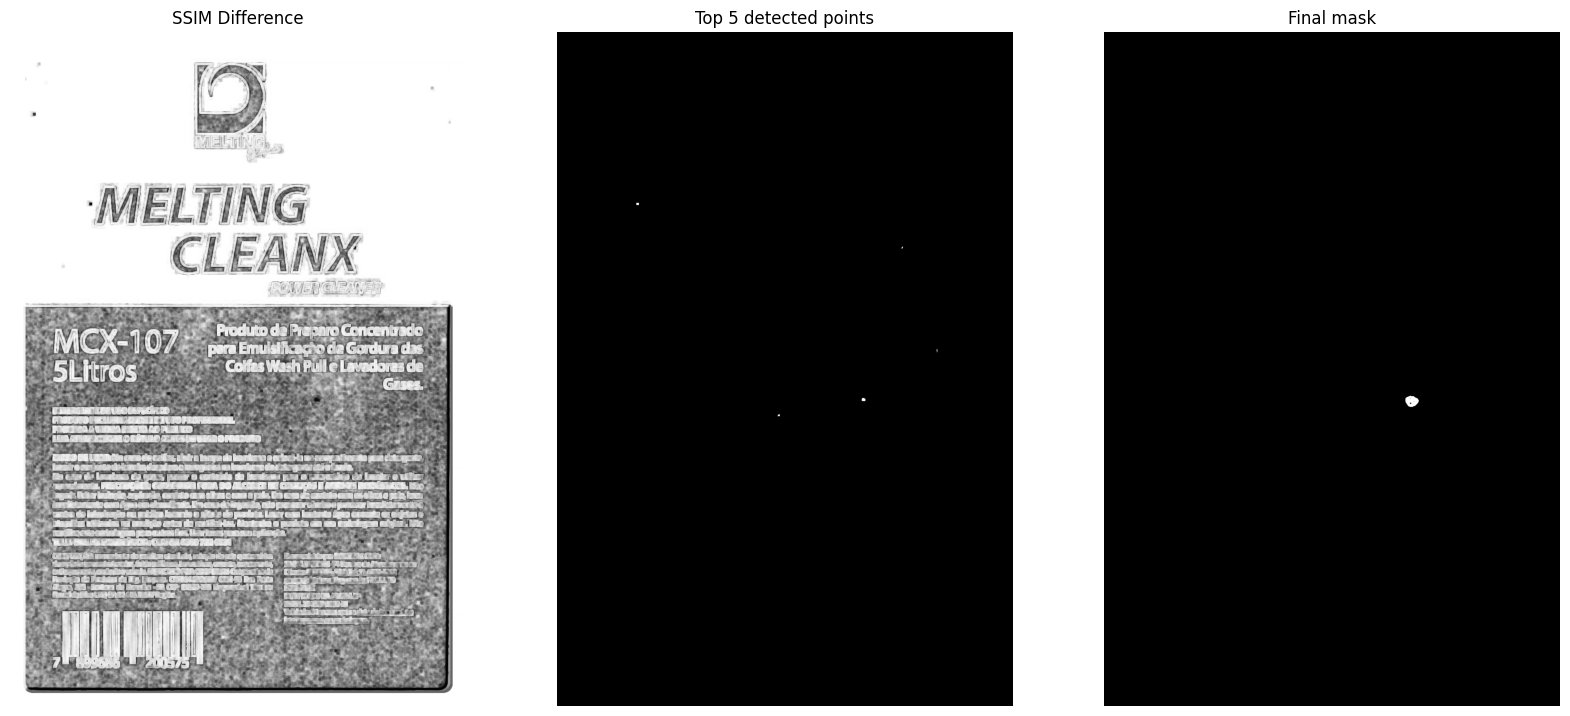

In [370]:
# Example usage
# Given contours in variable `given_contours`
# Another image in which to find new contours
# `image_to_search` should be defined

given_contours = stains_spots  # Replace with your contours variable
image_to_search = img1_filtered  # Replace with your image

centroids = find_contour_centroids(given_contours)
new_contours = find_contours_containing_centroids(image_to_search, centroids)

# Create a mask with the new contours
mask = np.zeros_like(image_to_search, dtype=np.uint8)
cv2.drawContours(mask, new_contours, -1, (255, 255, 255), thickness=cv2.FILLED)

# Apply the mask to black out areas not containing the centroids
image_with_new_contours = cv2.bitwise_and(image_to_search, mask)

# Display the images
titles = ['SSIM Difference', 'Top 5 detected points', 'Final mask']
images = [stains_diff, stains_mask, image_with_new_contours]

plt.figure(figsize=(20, 20))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(titles[i])
    if images[i].ndim == 2:  # if the image is grayscale
        plt.imshow(images[i], cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Optional: turn off axis for cleaner display
plt.show()

In [371]:
# Generate the dataframe with possible stains
image_area = image_with_new_contours.shape[0] * image_with_new_contours.shape[1]  # Total area of the image
contour_df = create_contour_dataframe(new_contours, image_area)

In [372]:
contour_df

Id                                            Contour   Area  \
0  Contour 1  [[[825, 983]], [[824, 984]], [[822, 984]], [[8...  755.5   

    Perimeter   Percent    Centroid  
0  106.325901  0.033767  (829, 997)

## 3 - Misalignment Detection

#### 3.1 - Functions

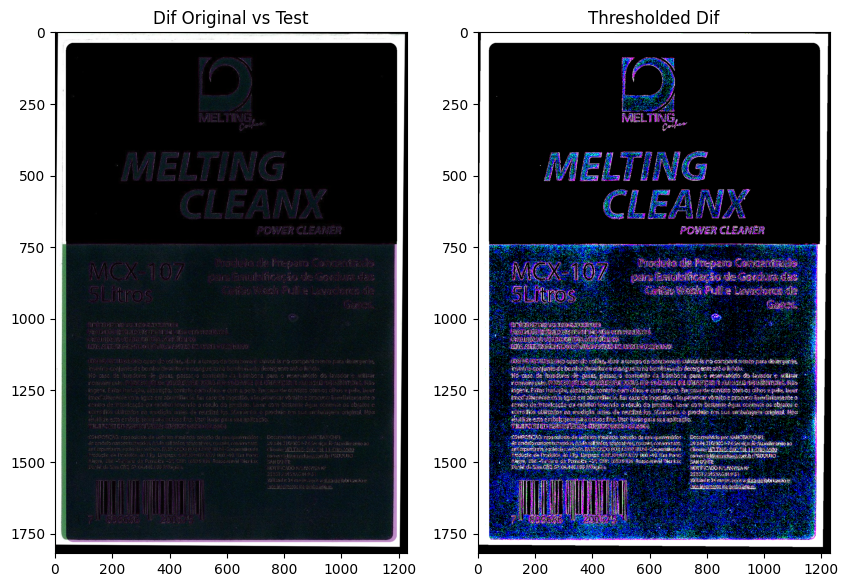

The area of differences between the two images is: 1361893 pixels


In [373]:
# Calculate the area of the differences (count non-zero pixels)
def calculate_difference_area(img):
    _, thresh = cv2.threshold(img, 30, 255, cv2.THRESH_BINARY)
    difference_area = np.count_nonzero(thresh)
    
    titles = ['Dif Original vs Test', 'Thresholded Dif']
    images = [img, thresh]
    # Optionally: Visualize the difference image
    plt.figure(figsize=(10, 10))
    for i in range(2):
        plt.subplot(1, 2, i + 1)
        plt.title(titles[i])
        plt.imshow(images[i])
    plt.show()
        
    return thresh, difference_area

# Calculate the area of differences
dif_original_test_thresh, area = calculate_difference_area(dif_original_test)
print(f"The area of differences between the two images is: {area} pixels")

In [374]:
def detect_and_draw_contours(image_thresh, mask_contour):
    gray = cv2.cvtColor(image_thresh, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 160, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_image = image_thresh.copy()
    cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)  # Draw in green color

    # Calculate the area of the differences (count non-zero pixels)
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, mask_contour, -1, 255, thickness=cv2.FILLED)
    masked_image = np.where(mask[:, :, None] == 255, image_thresh, [255, 255, 255])

    # Print the number of contours and their areas
    print(f"Number of contours found: {len(contours)}")
    for i, contour in enumerate(contours):
        area = cv2.contourArea(contour)
        print(f"Contour {i+1} area: {area:.2f} pixels")

    titles = ['Dif Original vs Test Thresh', 'Treated Dif']
    images = [image_thresh, masked_image]
    # Optionally: Visualize the difference image
    plt.figure(figsize=(10, 10))
    for i in range(2):
        plt.subplot(1, 2, i + 1)
        plt.title(titles[i])
        plt.imshow(images[i])
    plt.show()
    
    return contour_image

In [375]:
# Function to calculate the mean width and height of the contours
def calculate_mean_thickness(contours):
    vertical_lengths = []
    horizontal_lengths = []

    for contour in contours:
        # Get the bounding rectangle of the contour
        x, y, w, h = cv2.boundingRect(contour)

        # Consider the orientation of the bounding rectangle
        if h > w:  # Vertical part
            vertical_lengths.append(w)
        else:      # Horizontal part
            horizontal_lengths.append(h)

    mean_vertical_width = np.mean(vertical_lengths) if vertical_lengths else 0
    mean_horizontal_height = np.mean(horizontal_lengths) if horizontal_lengths else 0

    return mean_vertical_width, mean_horizontal_height

In [376]:
def detect_and_draw_contours(image_thresh, mask_contour):
    gray = cv2.cvtColor(image_thresh, cv2.COLOR_BGR2GRAY)
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, mask_contour, -1, 255, thickness=cv2.FILLED)
    # Change everything outside the mask contour to white
    masked_image = np.where(mask[:, :, None] == 255, image_thresh, [0, 0, 0])
    masked_image = masked_image.astype(np.uint8)

    gray2 = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)
    threshold_value = 150  # Adjusted based on the image's brightness
    _, thresh = cv2.threshold(gray2, threshold_value, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Filter contours by area and keep the largest one
    contour_areas = [(cv2.contourArea(contour), contour) for contour in contours]
    contour_areas.sort(reverse=True, key=lambda x: x[0])
    largest_contour = contour_areas[0][1]
    # Draw the contour on the original image
    highlighted_image = masked_image.copy()
    cv2.drawContours(highlighted_image, [largest_contour], -1, (0, 255, 0), 3)
    # Calculate area of the contour
    contour_area = cv2.contourArea(largest_contour)

    titles = ['Dif Original vs Test Thresh', 'Treated Dif', 'Highlighted Dif']
    images = [image_thresh, masked_image, highlighted_image]
    # Optionally: Visualize the difference image
    plt.figure(figsize=(15, 10))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(titles[i])
        plt.imshow(images[i])
    plt.show()
    
    return image_thresh, masked_image, contour_area

In [377]:
def create_bounding_box_dataframe(bbox, perimeters):
    data = []

    # Define the sides and their corresponding bounding boxes
    sides = ['Up', 'Bottom', 'Left', 'Right']
    for side, box, perimeter in zip(sides, bbox, perimeters):
        if box is not None:
            x, y, w, h = box
            area = w * h  # Calculate the area
            data.append({'Local': side, 'Area': area, 'Perimeter': perimeter, 'x': x, 'y': y, 'w': w, 'h': h})
        else:
            # If the bounding box is None, fill with NaN or 0
            data.append({'Local': side, 'Area': 0, 'Perimeter': 0, 'x': 0, 'y': 0, 'w': 0, 'h': 0})

    # Create a DataFrame from the data
    df = pd.DataFrame(data)
    return df

#### 3.2 - Execution

In [378]:
# Show the sum and abs difference
titles = ['Dif Original vs Test', 'Sum Original vs Test']
images = [dif_original_test, sum_original_test]

# Display the first three images in one row
plt.figure(figsize=(10, 10))
for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.title(titles[i])
    plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
plt.show()

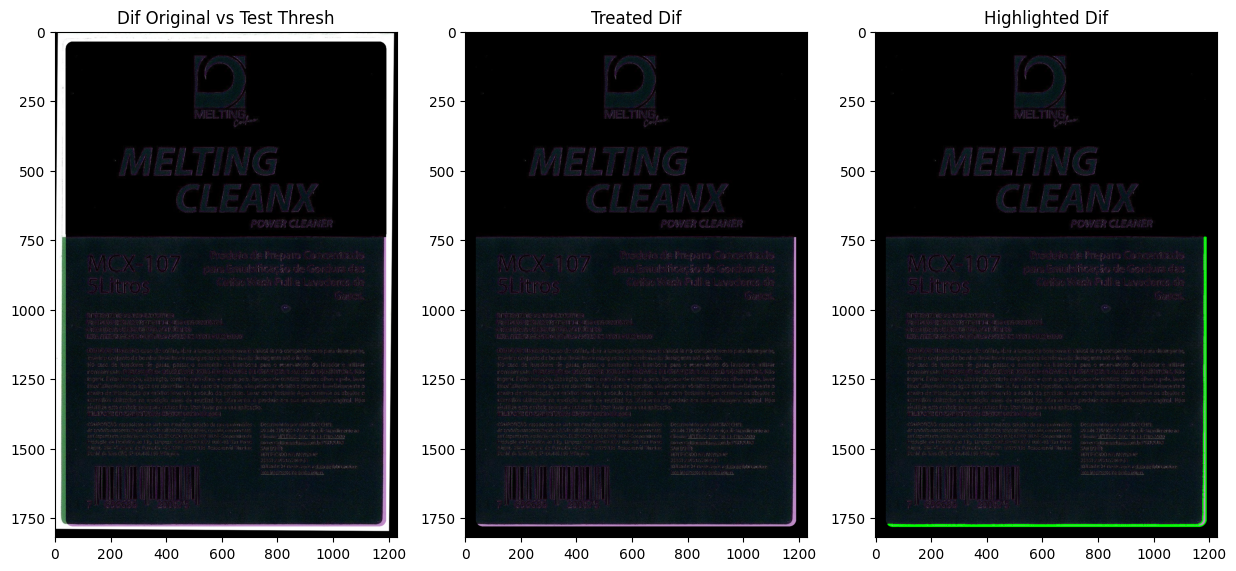

In [379]:
# Detect and draw contours
result_image1, result_image2, offset_area = detect_and_draw_contours(dif_original_test, original_image_contour)

In [380]:
contours = original_image_contour

# Get the dimensions of the image
height, width, _ = result_image2.shape

# Create a blank mask with the same shape as the original image (for example, 512x512)
image_shape = (height, width)  # Replace with actual dimensions of your image
mask = np.ones(image_shape, dtype=np.uint8) * 255

# Create a blank image for bounding boxes
bounding_box_image = np.zeros((height, width, 3), dtype=np.uint8)

# Set the expansion size (5 pixels for both inward and outward)
expansion_size = 50

# Loop through each contour
for contour in contours:
    contour_mask = np.zeros(image_shape, dtype=np.uint8)
    
    # Draw the contour on the individual mask (filled contour)
    cv2.drawContours(contour_mask, [contour], -1, (255), thickness=-1)
    
    # Expand outwards by dilating the contour
    expanded_outward = cv2.dilate(contour_mask, np.ones((expansion_size, expansion_size), np.uint8))
    
    # Expand inwards by eroding the contour
    expanded_inward = cv2.erode(contour_mask, np.ones((expansion_size, expansion_size), np.uint8))
    
    # Subtract the inner mask from the outer mask to isolate the area between
    contour_gap = cv2.subtract(expanded_outward, expanded_inward)
    
    # Apply the result to the final mask, setting the area between contours to black
    border_mask = cv2.bitwise_and(mask, cv2.bitwise_not(contour_gap))
    
    # Draw bounding box around the contour
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(bounding_box_image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Green bounding box

# Display the images
titles = ['Mask', 'Bounding Box Image']
images = [border_mask, bounding_box_image]

plt.figure(figsize=(10, 10))
for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.title(titles[i])
    plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    plt.axis('off')
plt.show()


In [381]:
contours = original_image_contour

# Get the dimensions of the image
height, width, _ = result_image2.shape

# Create a blank image to draw angle bisectors
cut_mask = border_mask.copy()

# Create blank images
bounding_box_image = np.zeros((height, width, 3), dtype=np.uint8)
corner_image = np.zeros((height, width, 3), dtype=np.uint8)
bisector_image = np.zeros((height, width, 3), dtype=np.uint8)

# Draw bounding boxes, corners, and angle bisectors
for contour in contours:
    # Draw bounding box around the contour
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(bounding_box_image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Green bounding box
    
    # Draw corners as red dots
    top_left = (x, y)
    top_right = (x + w, y)
    bottom_left = (x, y + h)
    bottom_right = (x + w, y + h)
    
    cv2.circle(corner_image, top_left, 5, (0, 0, 255), -1)  # Red dot
    cv2.circle(corner_image, top_right, 5, (0, 0, 255), -1)  # Red dot
    cv2.circle(corner_image, bottom_left, 5, (0, 0, 255), -1)  # Red dot
    cv2.circle(corner_image, bottom_right, 5, (0, 0, 255), -1)  # Red dot
    
    # Calculate the midpoint of the bounding box
    midpoint = (x + w // 2, y + h // 2)

    # Draw corners as red dots
    top_left = (0, 0)
    top_right = (0 + width, 0)
    bottom_left = (0, 0 + height)
    bottom_right = (0 + width, 0 + height)
    
    # Draw lines from each corner to the midpoint
    cv2.line(bisector_image, top_left, midpoint, (255, 0, 0), 2)  # Blue line
    cv2.line(bisector_image, top_right, midpoint, (255, 0, 0), 2)  # Blue line
    cv2.line(bisector_image, bottom_left, midpoint, (255, 0, 0), 2)  # Blue line
    cv2.line(bisector_image, bottom_right, midpoint, (255, 0, 0), 2)  # Blue line

    # Draw the angle bisectors (diagonals of the bounding box)
    cv2.line(cut_mask, top_left, bottom_right, (255, 255, 255), 30)  # White diagonal
    cv2.line(cut_mask, top_right, bottom_left, (255, 255, 255), 30)  # White diagonal

# Display the images
titles = ['Bounding Box Image', 'Corners Image', 'Bisector Image', 'Máscara Cortada']
images = [bounding_box_image, corner_image, bisector_image, cut_mask]

plt.figure(figsize=(30, 10))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(titles[i])
    plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    plt.axis('off')
plt.show()


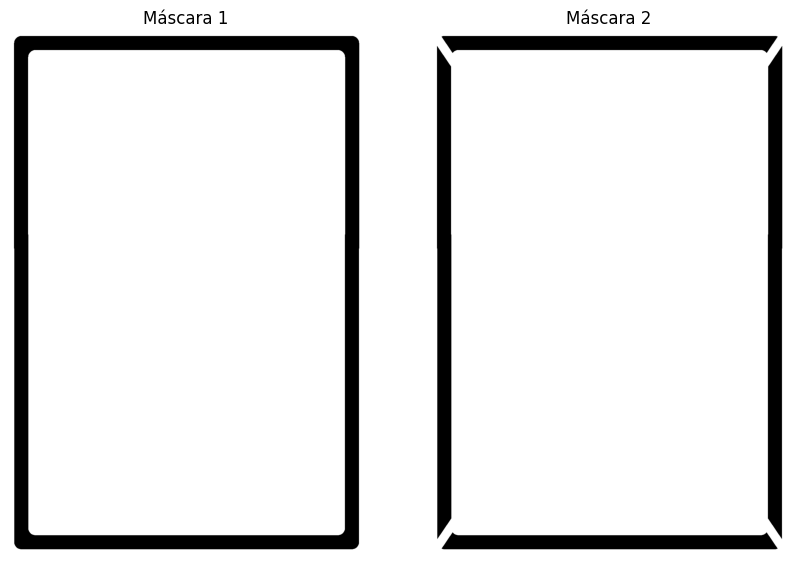

In [382]:
# Display the images
titles = ['Máscara 1', 'Máscara 2']
images = [border_mask, cut_mask]

plt.figure(figsize=(10, 10))
for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.title(titles[i])
    plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    plt.axis('off')
plt.show()

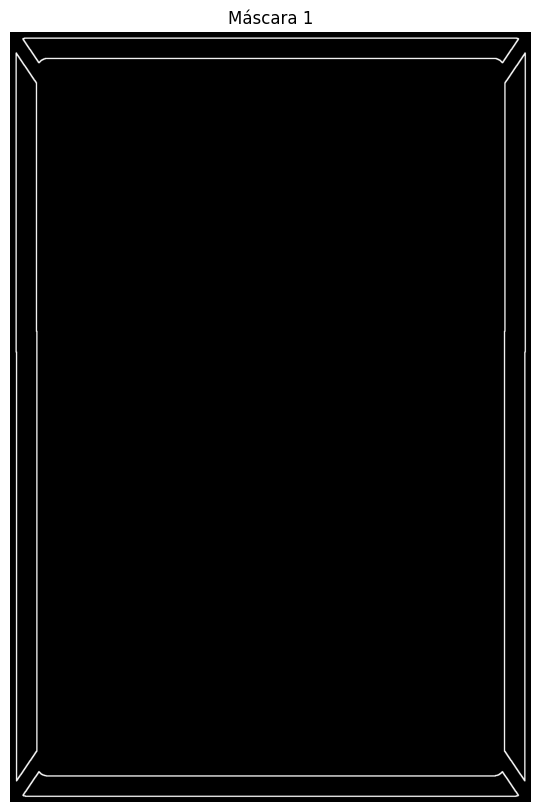

In [383]:
# Invert the image so that black areas (0) become white (255) and vice versa
inverted_image = cv2.bitwise_not(cut_mask)

# Find contours in the binary image
contours, _ = cv2.findContours(inverted_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

contour_image = np.zeros_like(inverted_image)
# Draw the current contour on the blank image
cv2.drawContours(contour_image, contours, -1, (255), thickness=2)  # White contour on black background

plt.figure(figsize=(10, 10))
for i in range(1):
    plt.subplot(1, 1, i + 1)
    plt.title(titles[i])
    plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
plt.show()

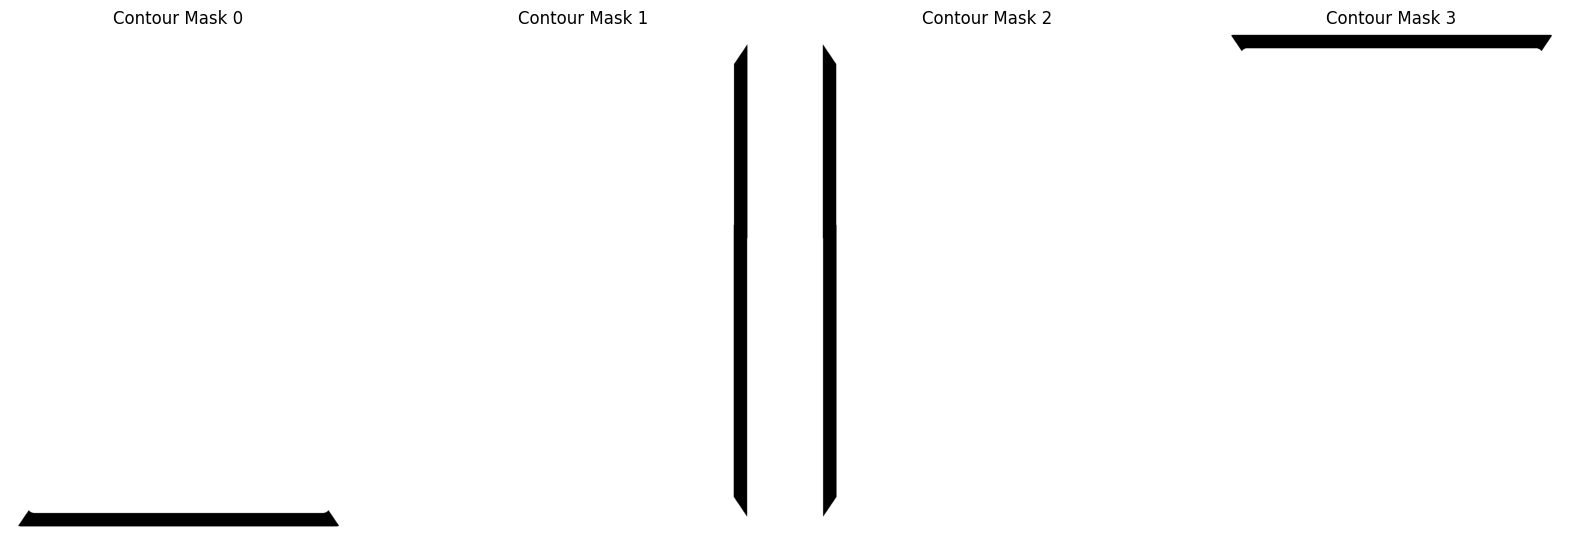

In [384]:
height, width, _ = result_image2.shape

# Invert the image so that black areas (0) become white (255) and vice versa
inverted_image = cv2.bitwise_not(cut_mask)

contours, _ = cv2.findContours(inverted_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour_masks = []

# Iterate through each contour
for i, contour in enumerate(contours):
    contour_mask = np.zeros((height, width), dtype=np.uint8) * 255
    cv2.drawContours(contour_mask, [contour], -1, (255), thickness=cv2.FILLED)  # Fill contour with white
    
    invert_mask = cv2.bitwise_not(contour_mask)
    contour_masks.append(invert_mask)

# Display the contour masks
plt.figure(figsize=(20, 20))
for i, mask in enumerate(contour_masks):
    plt.subplot(1, len(contour_masks), i + 1)
    plt.title(f'Contour Mask {i}')
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
plt.show()


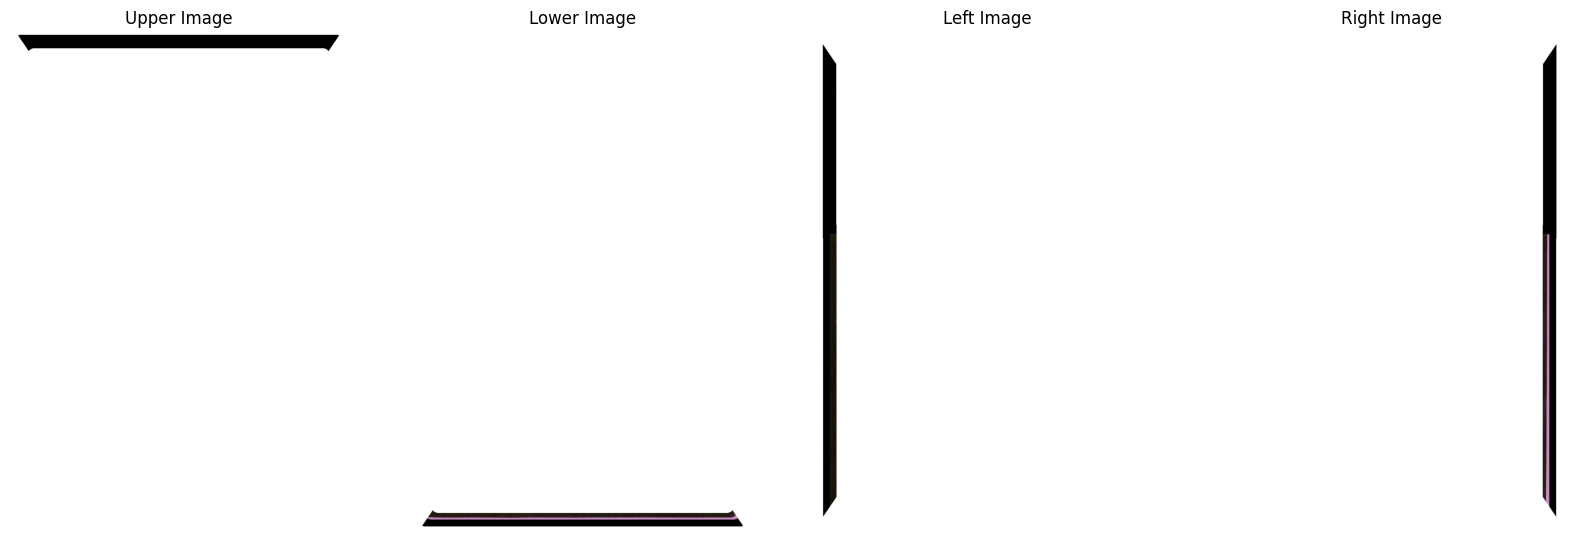

In [385]:
# Get the dimensions of the image
height, width, _ = result_image2.shape

# Create masks
mask_upper = np.ones((height, width), dtype=np.uint8) * 255
mask_lower = np.ones((height, width), dtype=np.uint8) * 255
mask_left = np.ones((height, width), dtype=np.uint8) * 255
mask_right = np.ones((height, width), dtype=np.uint8) * 255

# Define the Upper Mask (90% width, upper part, vertically centered)
mask_width = int(0.9 * width)
mask_height = height // 2
start_x = (width - mask_width) // 2
start_y = 0  # Start at the top of the image
mask_upper[start_y:start_y + mask_height, start_x:start_x + mask_width] = 0

# Define the Lower Half Mask (90% width, bottom part, vertically centered)
mask_lower[start_y + mask_height:, start_x:start_x + mask_width] = 0

# Define the Left Half Mask (90% height, left side)
mask_height = int(0.9 * height)
mask_width = width // 2
start_x = 0  # Start from the left side of the image
start_y = (height - mask_height) // 2
mask_left[start_y:start_y + mask_height, start_x:start_x + mask_width] = 0

# Define the Right Half Mask (90% height, right side)
start_x = width - mask_width
start_y = (height - mask_height) // 2
mask_right[start_y:start_y + mask_height, start_x:] = 0

# Apply the masks to the image
upper_image = np.where(contour_masks[3][:, :, None] == 0, result_image2, 255)
lower_image = np.where(contour_masks[0][:, :, None] == 0, result_image2, 255)
left_image = np.where(contour_masks[2][:, :, None] == 0, result_image2, 255)
right_image = np.where(contour_masks[1][:, :, None] == 0, result_image2, 255)

# Display the images
titles = ['Upper Image', 'Lower Image', 'Left Image', 'Right Image']
images = [upper_image, lower_image, left_image, right_image]

plt.figure(figsize=(20, 10))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(titles[i])
    plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    plt.axis('off')
plt.show()

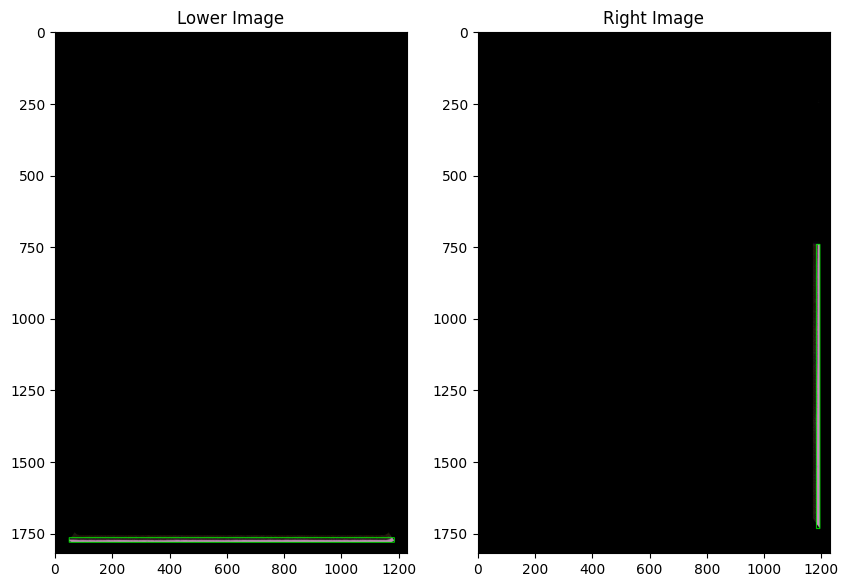

In [386]:
# Set areas outside the masks to black
upper_image[np.all(upper_image == [255, 255, 255], axis=-1)] = [0, 0, 0]
lower_image[np.all(lower_image == [255, 255, 255], axis=-1)] = [0, 0, 0]
left_image[np.all(left_image == [255, 255, 255], axis=-1)] = [0, 0, 0]
right_image[np.all(right_image == [255, 255, 255], axis=-1)] = [0, 0, 0]

# Find contours and bounding boxes
def find_bounding_box(image, threshold_value):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply threshold
    #threshold_value = 150  # Adjusted based on the image's brightness
    _, thresh = cv2.threshold(gray, threshold_value, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        perimeter_upper = cv2.arcLength(largest_contour, True)
        x, y, w, h = cv2.boundingRect(largest_contour)
        return (x, y, w, h), largest_contour, perimeter_upper
    else:
        return None, None, None

upper_bbox, upper_contour, upper_perimeter = find_bounding_box(upper_image, 150)
lower_bbox, lower_contour, lower_perimeter = find_bounding_box(lower_image, 150)
left_bbox, left_contour, left_perimeter = find_bounding_box(left_image, 150)
right_bbox, right_contour, right_perimeter = find_bounding_box(right_image, 150)

bbox = [upper_bbox, lower_bbox, left_bbox, right_bbox]
perimeters = [upper_perimeter, lower_perimeter, left_perimeter, right_perimeter]

# Draw bounding boxes on the images
if upper_bbox:
    x, y, w, h = upper_bbox
    cv2.rectangle(upper_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
if lower_bbox:
    x, y, w, h = lower_bbox
    cv2.rectangle(lower_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
if left_bbox:
    x, y, w, h = left_bbox
    cv2.rectangle(left_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
if right_bbox:
    x, y, w, h = right_bbox
    cv2.rectangle(right_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Display the images with bounding boxes
titles = ['Lower Image', 'Right Image']
images = [lower_image, right_image]

plt.figure(figsize=(10, 10))
for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.title(titles[i])
    plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
plt.show()

In [387]:
df_bounding_boxes = create_bounding_box_dataframe(bbox, perimeters)

In [388]:
# Show the results
df_bounding_boxes

Local   Area    Perimeter     x     y     w    h
0      Up      0     0.000000     0     0     0    0
1  Bottom  18128  2426.080296    49  1765  1133   16
2    Left      0     0.000000     0     0     0    0
3   Right  11904  2054.132030  1179   741    12  992

In [389]:
# Necessita de input manual?
# Sim: Threshold value no upper_bbox

## 4 - Misalignment of Colors

This code compares the Euclidian distance between the centroids of each colored contours for each color

#### 4.1 - Functions

In [390]:
# Function to find centroid of contours
def find_contour_centroids(contours):
    centroids = []
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            centroids.append((cX, cY))
    return centroids

In [391]:
# Calculates the euclidean distance between two points
def calculate_euclidean_distance(p1, p2):
    return sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

In [392]:
# Blacks out everything outside of the input image
def adjust_image(image, main_contour):
    new_img = image.copy()
    gray = cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY)

    mask = np.zeros_like(gray)
    cv2.drawContours(mask, main_contour, -1, 255, thickness=cv2.FILLED)
    new_img = np.where(mask[:, :, None] == 255, new_img, [255, 255, 255])
    new_img = new_img.astype(np.uint8)
    
    return new_img

In [393]:
# Function to show results
def show_results(titles, images):
    plt.figure(figsize=(20, 30))
    for i in range(len(images)):
        plt.subplot(4, 3, i + 1)
        plt.title(titles[i])
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [394]:
# Draw the found contours on the original image for visualization
def process_image(image, main_contour):
    adjusted_image = adjust_image(image, main_contour)
    gray = cv2.cvtColor(adjusted_image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(blur, 127, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(adjusted_image, contours, -1, (255, 255, 0), 2)

    # Display the results
    titles = ['Test With Contour', 'Thresh']
    images = [adjusted_image, thresh]
    
    show_results(titles, images)

In [395]:
def adjust_image(image, main_contour):
    new_img = image.copy()
    gray = cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY)

    mask = np.zeros_like(gray)
    cv2.drawContours(mask, main_contour, -1, 255, thickness=cv2.FILLED)
    new_img = np.where(mask[:, :, None] == 255, new_img, [255, 255, 255])
    new_img = new_img.astype(np.uint8)
    
    return new_img

In [396]:
# Dilates the given contours by a fixed number of pixels.
def dilate_contours(contours, pixels):
    dilated_contours = []
    kernel = np.ones((pixels * 2 + 1, pixels * 2 + 1), np.uint8)
    
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        mask = np.zeros((h + 2 * pixels, w + 2 * pixels), dtype=np.uint8)
        contour_shifted = contour - contour.min(axis=0)[0] + pixels
        cv2.drawContours(mask, [contour_shifted], -1, 255, thickness=cv2.FILLED)
        
        # Dilate the mask
        dilated_mask = cv2.dilate(mask, kernel, iterations=1)
    
        # Find the new contour
        dilated_contour, _ = cv2.findContours(dilated_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        dilated_contour = dilated_contour[0] + contour.min(axis=0)[0] - pixels
        dilated_contours.append(dilated_contour)
    
    return dilated_contours

In [397]:
# Find contours of the image
def find_contours(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(blur, 127, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    dilated_contours1 = dilate_contours(contours, pixels=5)
    qtycontours = len(dilated_contours1)

    img_contour = img.copy()
    cv2.drawContours(img_contour, dilated_contours1, -1, (255, 255, 0), 2)

    return qtycontours, dilated_contours1, thresh, img_contour

In [398]:
# Get the area of the largest contour
def get_largest_contour_area(contours):
    if not contours:
        return 0  # Return None if the list is empty

    largest_contour = max(contours, key=cv2.contourArea)
    largest_contour_area = cv2.contourArea(largest_contour)
    return largest_contour_area

In [399]:
def generate_centroid_table(centroids_list, areas_list, original_contours):
    # Create a DataFrame to hold the centroid information
    max_contours = max(len(centroids) for centroids in centroids_list)
    table_data = {
        "Contours": list(range(1, max_contours + 1)),
        "Original Contour": [None] * max_contours,  # New column for original contours
        "Centroid Red": [None] * max_contours,
        "Area Red": [None] * max_contours,
        "Centroid Green": [None] * max_contours,
        "Area Green": [None] * max_contours,
        "Centroid Blue": [None] * max_contours,
        "Area Blue": [None] * max_contours,
        "Dif Red Green": [None] * max_contours,
        "Dif Red Blue": [None] * max_contours,
        "Dif Green Blue": [None] * max_contours,
    }

    # Fill the DataFrame with centroid coordinates, areas, and original contours
    for i in range(max_contours):  # Iterate through contours
        if i < len(original_contours):
            table_data["Original Contour"][i] = original_contours[i]  # Add original contour
        if i < len(centroids_list[0]):
            table_data["Centroid Red"][i] = centroids_list[0][i]
            table_data["Area Red"][i] = areas_list[0][i] if i < len(areas_list[0]) else None
        if i < len(centroids_list[1]):
            table_data["Centroid Green"][i] = centroids_list[1][i]
            table_data["Area Green"][i] = areas_list[1][i] if i < len(areas_list[1]) else None
        if i < len(centroids_list[2]):
            table_data["Centroid Blue"][i] = centroids_list[2][i]
            table_data["Area Blue"][i] = areas_list[2][i] if i < len(areas_list[2]) else None

    # Calculate Euclidean distances
    for i in range(max_contours):
        if table_data["Centroid Red"][i] is not None and table_data["Centroid Green"][i] is not None:
            table_data["Dif Red Green"][i] = calculate_euclidean_distance(
                table_data["Centroid Red"][i], table_data["Centroid Green"][i]
            )
        if table_data["Centroid Red"][i] is not None and table_data["Centroid Blue"][i] is not None:
            table_data["Dif Red Blue"][i] = calculate_euclidean_distance(
                table_data["Centroid Red"][i], table_data["Centroid Blue"][i]
            )
        if table_data["Centroid Green"][i] is not None and table_data["Centroid Blue"][i] is not None:
            table_data["Dif Green Blue"][i] = calculate_euclidean_distance(
                table_data["Centroid Green"][i], table_data["Centroid Blue"][i]
            )

    # Convert to a DataFrame and return
    centroid_df = pd.DataFrame(table_data)
    return centroid_df

In [400]:
def process_image_color_check(image, main_contour):
    adjusted_image = adjust_image(image, main_contour)
    qtycontours, contours, img_thresh, img_contour = find_contours(adjusted_image)
    
    colors = ['b', 'g', 'r']
    centroids_list = []
    contour_areas_list = []
    
    # Split the image into BGR channels
    channels = cv2.split(adjusted_image)

    # Initialize the colored images for each channel
    b_colored = cv2.merge([channels[0], np.zeros_like(channels[0]), np.zeros_like(channels[0])])
    g_colored = cv2.merge([np.zeros_like(channels[1]), channels[1], np.zeros_like(channels[1])])
    r_colored = cv2.merge([np.zeros_like(channels[2]), np.zeros_like(channels[2]), channels[2]])
    coloreds = [b_colored, g_colored, r_colored]

    for i, color in enumerate(colors):
        centroids_sublist = []
        contour_areas = []
        for c, contour in enumerate(contours):
            # Create Mask
            masks = np.zeros_like(channels[i])

            # Draw original contour in the mask 
            cv2.drawContours(masks, [contour], -1, 255, thickness=cv2.FILLED)

            # Merge mask with the colored image (splitted)
            channel_bit = cv2.bitwise_and(channels[i], channels[i], mask=masks)

            # Process to find new contour
            t = cv2.cvtColor(channel_bit, cv2.COLOR_GRAY2BGR)
            white_pixels = np.where((t == np.array([0, 0, 0])).all(axis=2))
            t[white_pixels] = [255, 255, 255]
            _, t = cv2.threshold(t, 200, 255, cv2.THRESH_BINARY_INV)
            t = cv2.cvtColor(t, cv2.COLOR_BGR2GRAY)

            # Find new contour of merged colored img
            inner_contours, _ = cv2.findContours(t, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            contour_area = get_largest_contour_area(inner_contours)
            #print(get_largest_contour_area(inner_contours))

            # Draw new contour on colored img
            cv2.drawContours(coloreds[i], inner_contours, -1, (255, 255, 255), 2)

            # Find the centroid of contour and insert in a list
            centroids_sublist.extend(find_contour_centroids(inner_contours))
            # Find the area of contour and insert in a list
            contour_areas.append(contour_area)

        centroids_list.append(centroids_sublist)
        contour_areas_list.append(contour_areas)

    # Generate the centroid table
    centroid_table = generate_centroid_table(centroids_list, contour_areas_list, contours)
    return centroid_table

In [401]:
# Check for the differences between the centroids and generate the table
def process_image_color_check_v2(image, main_contour):
    adjusted_image = adjust_image(image, main_contour)
    qtycontours, contours, img_thresh, img_contour = find_contours(adjusted_image)
    
    colors = ['Red', 'Green', 'Blue']
    color_pairs = [('Red', 'Green'), ('Red', 'Blue'), ('Green', 'Blue')]
    centroids_list = []
    contour_areas_list = []
    
    # Split the image into BGR channels
    channels = cv2.split(adjusted_image)

    for i, color in enumerate(colors):
        centroids_sublist = []
        contour_areas = []
        for contour in contours:
            # Create Mask
            masks = np.zeros_like(channels[i])

            # Draw original contour in the mask 
            cv2.drawContours(masks, [contour], -1, 255, thickness=cv2.FILLED)

            # Merge mask with the colored image (splitted)
            channel_bit = cv2.bitwise_and(channels[i], channels[i], mask=masks)

            # Process to find new contour
            t = cv2.cvtColor(channel_bit, cv2.COLOR_GRAY2BGR)
            white_pixels = np.where((t == np.array([0, 0, 0])).all(axis=2))
            t[white_pixels] = [255, 255, 255]
            _, t = cv2.threshold(t, 200, 255, cv2.THRESH_BINARY_INV)
            t = cv2.cvtColor(t, cv2.COLOR_BGR2GRAY)

            # Find new contour of merged colored img
            inner_contours, _ = cv2.findContours(t, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            contour_area = get_largest_contour_area(inner_contours)

            # Find the centroid of contour and insert in a list
            centroids_sublist.extend(find_contour_centroids(inner_contours))
            # Find the area of contour and insert in a list
            contour_areas.append(contour_area)

        centroids_list.append(centroids_sublist)
        contour_areas_list.append(contour_areas)

    # Create the first DataFrame for Centroids and Areas
    data_1 = []
    for i, color in enumerate(colors):
        for j, contour in enumerate(contours):
            if j < len(centroids_list[i]) and j < len(contour_areas_list[i]):
                data_1.append({
                    'Contours': f'Contour {j+1}',
                    'Original Contour': contours[j],
                    'Category': color,
                    'Centroid': centroids_list[i][j],
                    'Area': contour_areas_list[i][j],
                })

    df_centroids_areas = pd.DataFrame(data_1)

    # Create the second DataFrame for Differences and Euclidean distances
    data_2 = []
    for j, contour in enumerate(contours):
        for k, (color1, color2) in enumerate(color_pairs):
            if k < len(contour_areas_list) - 1 and j < len(contour_areas_list[k]) and j < len(contour_areas_list[k+1]):
                # Calculate the area difference
                diff_value = abs(contour_areas_list[k][j] - contour_areas_list[k+1][j])

                # Calculate the Euclidean distance between centroids
                centroid1 = np.array(centroids_list[k][j])
                centroid2 = np.array(centroids_list[k+1][j])
                euc_dist = np.linalg.norm(centroid1 - centroid2)

                data_2.append({
                    'Contours': f'Contour {j+1}',
                    'Original Contour': contours[j],
                    'Category': f'{color1}-{color2}',
                    'Dif': diff_value,
                    'Euclidean Distance': euc_dist,
                })

    df_differences = pd.DataFrame(data_2)

    return df_centroids_areas, df_differences


In [402]:
# Function to plot the histograms with the differences between the centorids
def plot_dif_histograms(centroid_df):
    # Extract the difference columns
    dif_red_green = centroid_df["Dif Red Green"].dropna()
    dif_red_blue = centroid_df["Dif Red Blue"].dropna()
    dif_green_blue = centroid_df["Dif Green Blue"].dropna()

    dif_red_green = dif_red_green[dif_red_green > 0]
    dif_red_blue = dif_red_blue[dif_red_blue > 0]
    dif_green_blue = dif_green_blue[dif_green_blue > 0]

    # Create subplots for histograms
    plt.figure(figsize=(18, 5))

    # Histogram for Dif Red Green
    plt.subplot(1, 3, 1)
    plt.hist(dif_red_green, bins=20, color='#F8E3A2')
    plt.title('Histogram of Dif Red Green')
    plt.xlabel('Distance')
    plt.ylabel('Frequency')

    # Histogram for Dif Red Blue
    plt.subplot(1, 3, 2)
    plt.hist(dif_red_blue, bins=20, color='#F5A6B0')
    plt.title('Histogram of Dif Red Blue')
    plt.xlabel('Distance')
    plt.ylabel('Frequency')

    # Histogram for Dif Green Blue
    plt.subplot(1, 3, 3)
    plt.hist(dif_green_blue, bins=20, color='#A2D8E6')
    plt.title('Histogram of Dif Green Blue')
    plt.xlabel('Distance')
    plt.ylabel('Frequency')

    # Show the plots
    plt.tight_layout()
    plt.show()

In [403]:
# Function to draw the top contours with highest difference in the original image
def draw_top_contours(image, dataframe, top_n):
    # Sort the dataframe by contour area or other criteria
    sorted_df = dataframe.sort_values(by="Dif", ascending=False)

    # Select the top N contours
    top_contours = sorted_df['Original Contour'].head(top_n)
    for contour in top_contours:
        cv2.drawContours(image, [contour], -1, (255, 0, 0), 2)  # Draw in green with thickness 2
    
    plt.figure(figsize=(15, 10))
    plt.title('Tested Image with contours misalignment')
    plt.imshow(image)
    plt.show()

#### 4.2 - Execution

In [404]:
# Example function call
centroids = process_image_color_check(test_aligned_w_contour, original_image_contour)

In [405]:
centroids_v2, dif_v2 = process_image_color_check_v2(test_aligned_w_contour, original_image_contour)

In [406]:
centroids

Contours                                   Original Contour  Centroid Red  \
0          1  [[[721, 1766]], [[721, 1776]], [[732, 1776]], ...   (726, 1769)   
1          2  [[[1167, 1756]], [[1166, 1757]], [[1166, 1767]...  (1170, 1760)   
2          3  [[[1169, 1371]], [[1169, 1382]], [[1180, 1382]...  (1174, 1376)   
3          4  [[[1173, 1363]], [[1173, 1373]], [[1183, 1373]...  (1176, 1368)   
4          5  [[[1169, 1361]], [[1169, 1371]], [[1180, 1371]...  (1174, 1366)   
..       ...                                                ...           ...   
62        63                                               None    (617, 297)   
63        64                                               None    (667, 258)   
64        65                                               None    (671, 102)   
65        66                                               None    (592, 192)   
66        67                                               None          None   

    Area Red Centroid Green  Area Green Centroid Blue  Area Blue  \
0       77.0    (726, 1769)        69.0   (726, 1769)       77.0   
1       88.0   (1170, 1760)        86.5  (1170, 1760)       88.0   
2      121.0   (1174, 1376)       120.0  (1174, 1376)      121.0   
3       72.0   (1176, 1368)        69.0  (1176, 1368)       72.0   
4      110.0   (1174, 1365)       108.0  (1174, 1366)      110.0   
..       ...            ...         ...           ...        ...   
62       NaN     (667, 258)         NaN    (611, 286)        NaN   
63       NaN     (671, 102)         NaN    (617, 297)        NaN   
64       NaN     (593, 192)         NaN    (667, 259)        NaN   
65       NaN           None         NaN    (671, 102)        NaN   
66       NaN           None         NaN    (592, 192)        NaN   

    Dif Red Green  Dif Red Blue  Dif Green Blue  
0        0.000000      0.000000        0.000000  
1        0.000000      0.000000        0.000000  
2        0.000000      0.000000        0.000000  
3        0.000000      0.000000        0.000000  
4        1.000000      0.000000        1.000000  
..            ...           ...             ...  
62      63.411355     12.529964       62.609903  
63     156.051274     63.411355      202.338825  
64     119.096599    157.050947       99.824847  
65            NaN    119.753914             NaN  
66            NaN           NaN             NaN  

[67 rows x 11 columns]

In [407]:
# Show first version of results table
centroids_v2

Contours                                   Original Contour Category  \
0     Contour 1  [[[721, 1766]], [[721, 1776]], [[732, 1776]], ...      Red   
1     Contour 2  [[[1167, 1756]], [[1166, 1757]], [[1166, 1767]...      Red   
2     Contour 3  [[[1169, 1371]], [[1169, 1382]], [[1180, 1382]...      Red   
3     Contour 4  [[[1173, 1363]], [[1173, 1373]], [[1183, 1373]...      Red   
4     Contour 5  [[[1169, 1361]], [[1169, 1371]], [[1180, 1371]...      Red   
..          ...                                                ...      ...   
172  Contour 55  [[[667, 279]], [[666, 280]], [[660, 280]], [[6...     Blue   
173  Contour 56  [[[612, 279]], [[611, 280]], [[611, 316]], [[6...     Blue   
174  Contour 57  [[[678, 216]], [[678, 217]], [[677, 218]], [[6...     Blue   
175  Contour 58  [[[655, 85]], [[654, 86]], [[642, 86]], [[642,...     Blue   
176  Contour 59  [[[585, 85]], [[584, 86]], [[578, 86]], [[577,...     Blue   

         Centroid     Area  
0     (726, 1769)     77.0  
1    (1170, 1760)     88.0  
2    (1174, 1376)    121.0  
3    (1176, 1368)     72.0  
4    (1174, 1366)    110.0  
..            ...      ...  
172    (640, 298)    447.0  
173    (614, 287)    177.0  
174    (599, 293)   1326.0  
175    (573, 301)    760.0  
176    (551, 297)  17702.0  

[177 rows x 5 columns]

In [408]:
# Show second version of the table results (transformed)
dif_v2.sort_values(by="Euclidean Distance", ascending=False)

Contours                                   Original Contour   Category  \
62  Contour 32  [[[447, 416]], [[447, 418]], [[446, 419]], [[4...  Red-Green   
63  Contour 32  [[[447, 416]], [[447, 418]], [[446, 419]], [[4...   Red-Blue   
66  Contour 34  [[[317, 416]], [[316, 417]], [[316, 419]], [[3...  Red-Green   
67  Contour 34  [[[317, 416]], [[316, 417]], [[316, 419]], [[3...   Red-Blue   
74  Contour 38  [[[640, 334]], [[640, 347]], [[641, 348]], [[6...  Red-Green   
..         ...                                                ...        ...   
16   Contour 9  [[[1174, 1125]], [[1174, 1135]], [[1185, 1135]...  Red-Green   
15   Contour 8  [[[1173, 1344]], [[1172, 1345]], [[1172, 1355]...   Red-Blue   
39  Contour 20  [[[914, 674]], [[913, 675]], [[912, 675]], [[9...   Red-Blue   
13   Contour 7  [[[1173, 1351]], [[1173, 1362]], [[1183, 1362]...   Red-Blue   
0    Contour 1  [[[721, 1766]], [[721, 1776]], [[732, 1776]], ...  Red-Green   

      Dif  Euclidean Distance  
62   83.0          429.004662  
63   72.0          429.004662  
66  218.0          313.081459  
67  195.0          313.081459  
74    7.5          294.006803  
..    ...                 ...  
16    0.0            0.000000  
15    3.5            0.000000  
39   17.0            0.000000  
13    4.0            0.000000  
0     8.0            0.000000  

[118 rows x 5 columns]

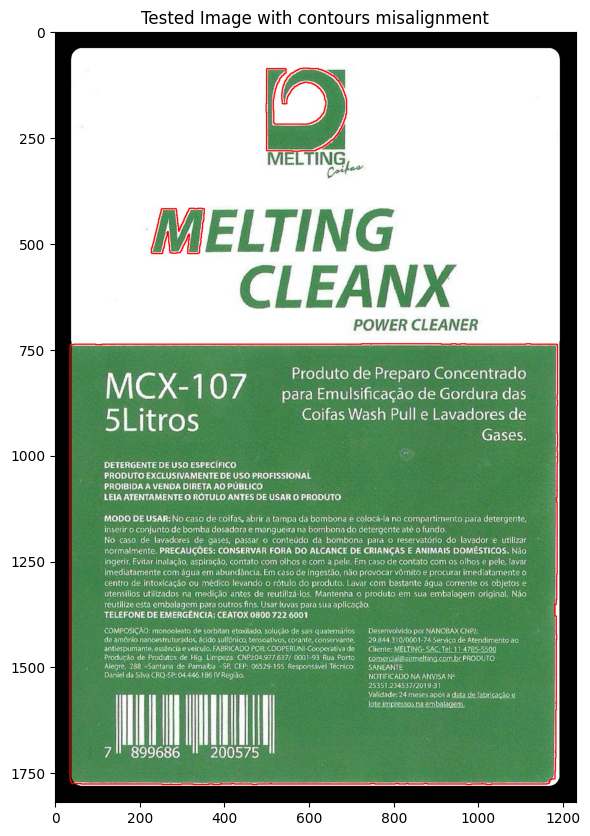

In [409]:
# Show the original image with the contours with highest difference
copy_test = test_aligned_w_contour.copy()
draw_top_contours(copy_test, dif_v2, 5)

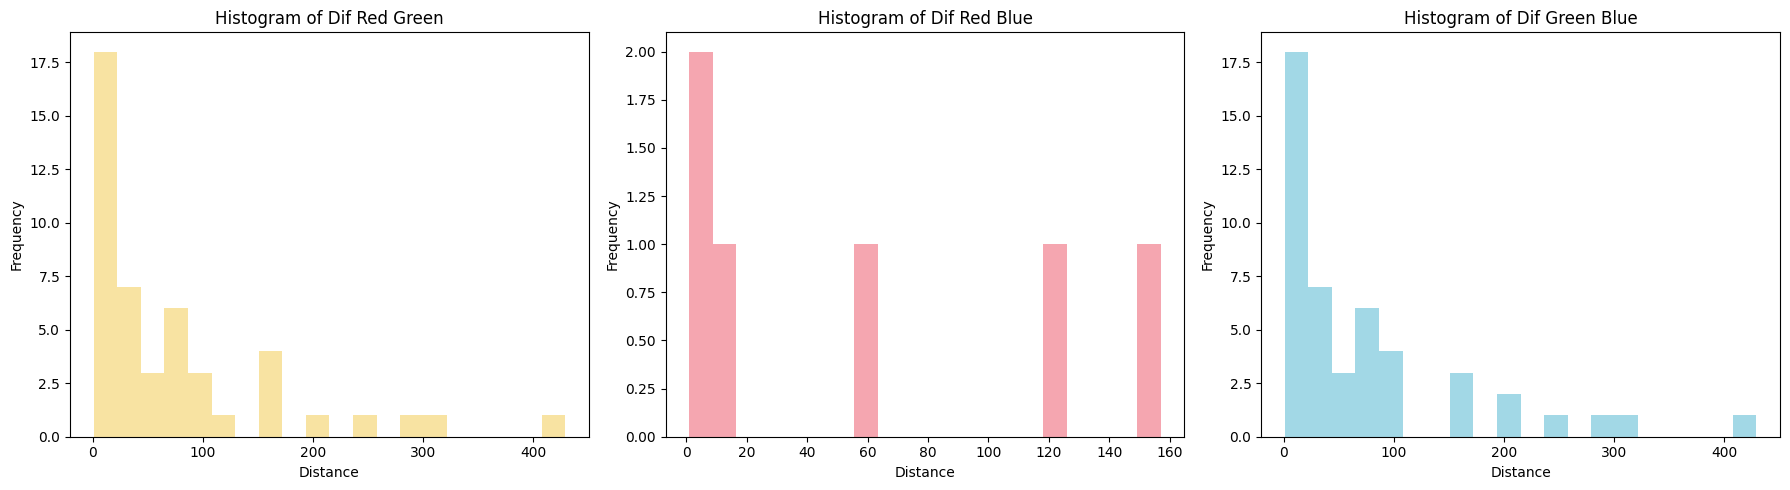

In [410]:
# Assuming centroid_df is your DataFrame from generate_centroid_table
plot_dif_histograms(centroids)